In [5]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

In [7]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

In [5]:
bacdive['growth_data'].count(axis=0).sum()

28553

# Figure 1

See `figure_1.ipynb`. I have to seperate it to a different notebook to run on a different conda environment with older Python because of ete3 compatibility issue. 

# Figure 2

## 2A: Phylogeny models

In [4]:
# Zeqian 16S
from genomics_utils import IO
zeqian_sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
zeqian_sixteenS_data=pd.DataFrame([list(s) for s in zeqian_sixteenS_data.seq],index=zeqian_sixteenS_data.id)
zeqian_sixteenS_data=zeqian_sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
zeqian_sixteenS_data.index=zeqian_sixteenS_data.index.str.replace('zeqian_','')
zeqian_sixteenS_data=zeqian_sixteenS_data.loc[zeqian['samples']]

matti_sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
matti_sixteenS_data=pd.DataFrame([list(s) for s in matti_sixteenS_data.seq],index=matti_sixteenS_data.id)
matti_sixteenS_data=matti_sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
matti_sixteenS_data.index=matti_sixteenS_data.index.str.replace('matti_','')
matti_sixteenS_data=matti_sixteenS_data.loc[matti['samples']]

In [5]:
threads=48
p=None
#p=Pool(threads)

In [6]:
DIR_figure=f"{DIR_data}/figure_data/2A"


models={'fba':[FBAClassifier, # This will throw an error for Matti's data, but it will be automatically skipped. 
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads': threads,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
        #         'threads':threads,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],

        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        
}

matrices={'zeqian_16s': {'ko_data': zeqian_sixteenS_data, 'growth_data':zeqian['growth_data'],'carbons':zeqian['carbons'],'tree':zeqian['tree'],'samples':zeqian['samples']},
         'matti_16s': {'ko_data': matti_sixteenS_data, 'growth_data':matti['growth_data'],'carbons':matti['carbons'],'tree':matti['tree'],'samples':matti['samples']}}

In [7]:
results_all=run_multiple_models(models, matrices, DIR_figure,p=None)

Traceback (most recent call last):
  File "/home/zeqianli/Kuehn/Carbon/utils/prediction_models.py", line 1341, in run_multiple_models
    pipe=PredictionPipeline(Model, **params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zeqianli/Kuehn/Carbon/utils/prediction_models.py", line 1146, in __init__
    raise ValueError("A Pool object is required for multi-threading.")
ValueError: A Pool object is required for multi-threading.


Running models...
Running zeqian_16s fba
Already exists. Skipping. 
Running matti_16s fba
Failed to run matti_16s fba
Running zeqian_16s null
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/zeqian_16s_null_0.pk. 


Training models...: 100%|██████████| 1000/1000 [00:10<00:00, 92.08it/s]


Finished zeqian_16s null 
Running matti_16s null
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/matti_16s_null_0.pk. 


Training models...: 100%|██████████| 10000/10000 [04:43<00:00, 35.24it/s]


Finished matti_16s null 
Running zeqian_16s identity_null


Training models...: 100%|██████████| 1000/1000 [00:11<00:00, 88.57it/s]


Finished zeqian_16s identity_null 
Running matti_16s identity_null


Training models...: 100%|██████████| 10000/10000 [04:54<00:00, 33.99it/s]


Finished matti_16s identity_null 
Running zeqian_16s NN
Already exists. Skipping. 
Running matti_16s NN
Already exists. Skipping. 
Running zeqian_16s null_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/zeqian_16s_null_ooc_0.pk. 


Training models...: 100%|██████████| 1000/1000 [00:11<00:00, 88.01it/s]


Finished zeqian_16s null_ooc 
Running matti_16s null_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/cache/matti_16s_null_ooc_0.pk. 


Training models...: 100%|██████████| 10000/10000 [04:49<00:00, 34.52it/s]


Finished matti_16s null_ooc 
Running zeqian_16s identity_null_ooc


Training models...: 100%|██████████| 1000/1000 [00:12<00:00, 78.11it/s]


Finished zeqian_16s identity_null_ooc 
Running matti_16s identity_null_ooc


Training models...: 100%|██████████| 10000/10000 [04:56<00:00, 33.69it/s]


Finished matti_16s identity_null_ooc 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running matti_16s NN_ooc
Already exists. Skipping. 
Running models done.
Concatenating data...
[Errno 2] No such file or directory: '/home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/results/matti_16s_fba.pk'
Failed to load matti_16s fba
Concatenating data done.


In [4]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2A/results_all.pk")
results_all=results_all[results_all['dataset_name']=='zeqian_16s']

model_pairs=[('fba', 'null'),  ('NN', 'null'), ('NN_ooc', 'null_ooc'),('fba', 'identity_null'),  ('NN', 'identity_null'), ('NN_ooc', 'identity_null_ooc')]
stats=compare_models(results_all, 
                    model_pairs=[('fba', 'null',one_sample_test), ('NN', 'null',ttest_permutation), ('NN_ooc', 'null_ooc',ttest_permutation),('fba', 'identity_null',one_sample_test), ('NN', 'identity_null',ttest_permutation), ('NN_ooc', 'identity_null_ooc',ttest_permutation)],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction='hs',correct_by='carbons').set_index('carbon_name')

100%|██████████| 10/10 [00:32<00:00,  3.27s/it]

Correcting p-values...


['null', 'identity_null']


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


['null_ooc', 'identity_null_ooc']


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


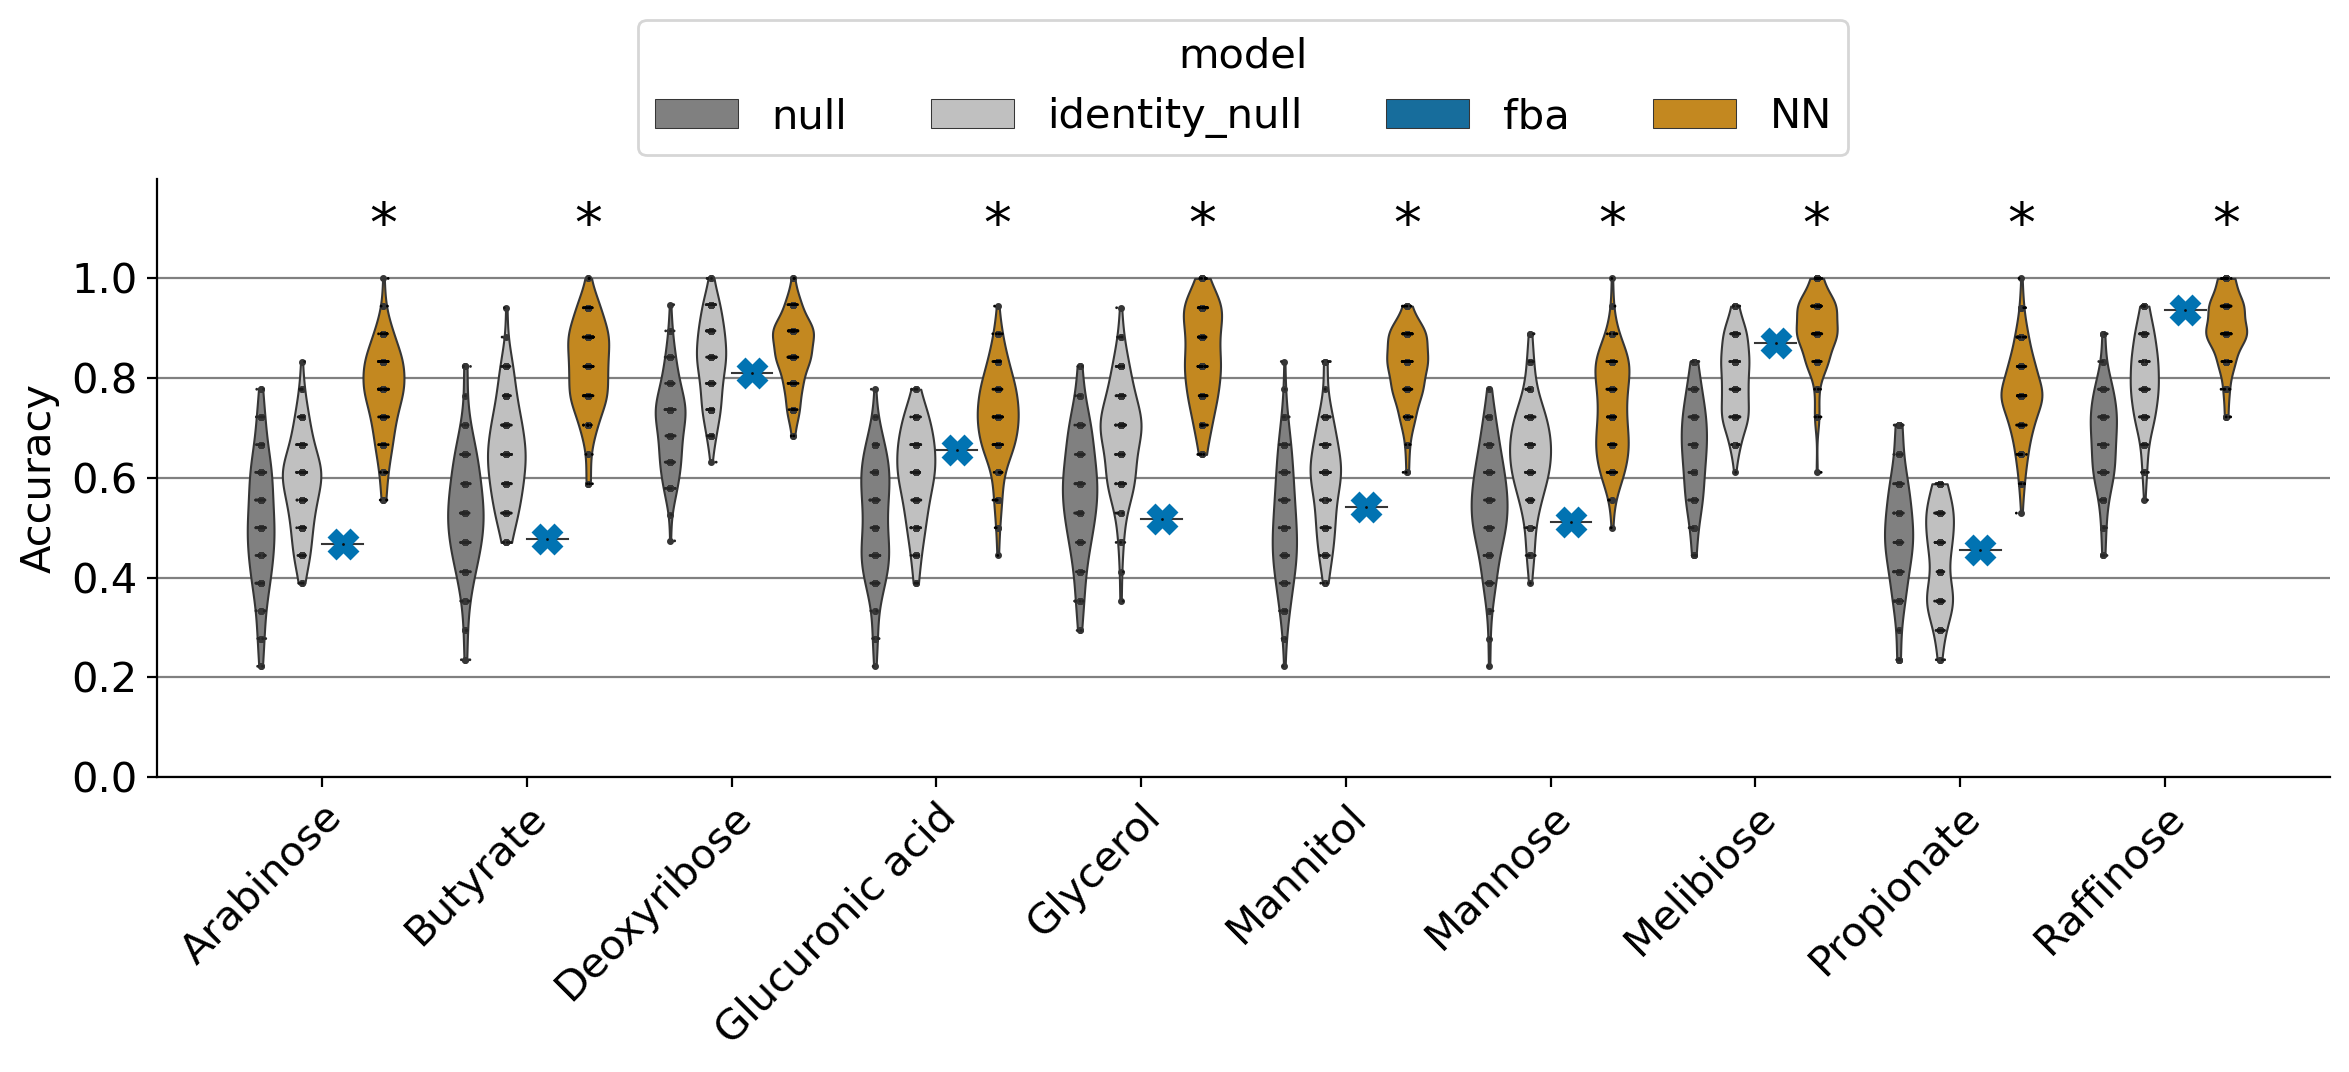

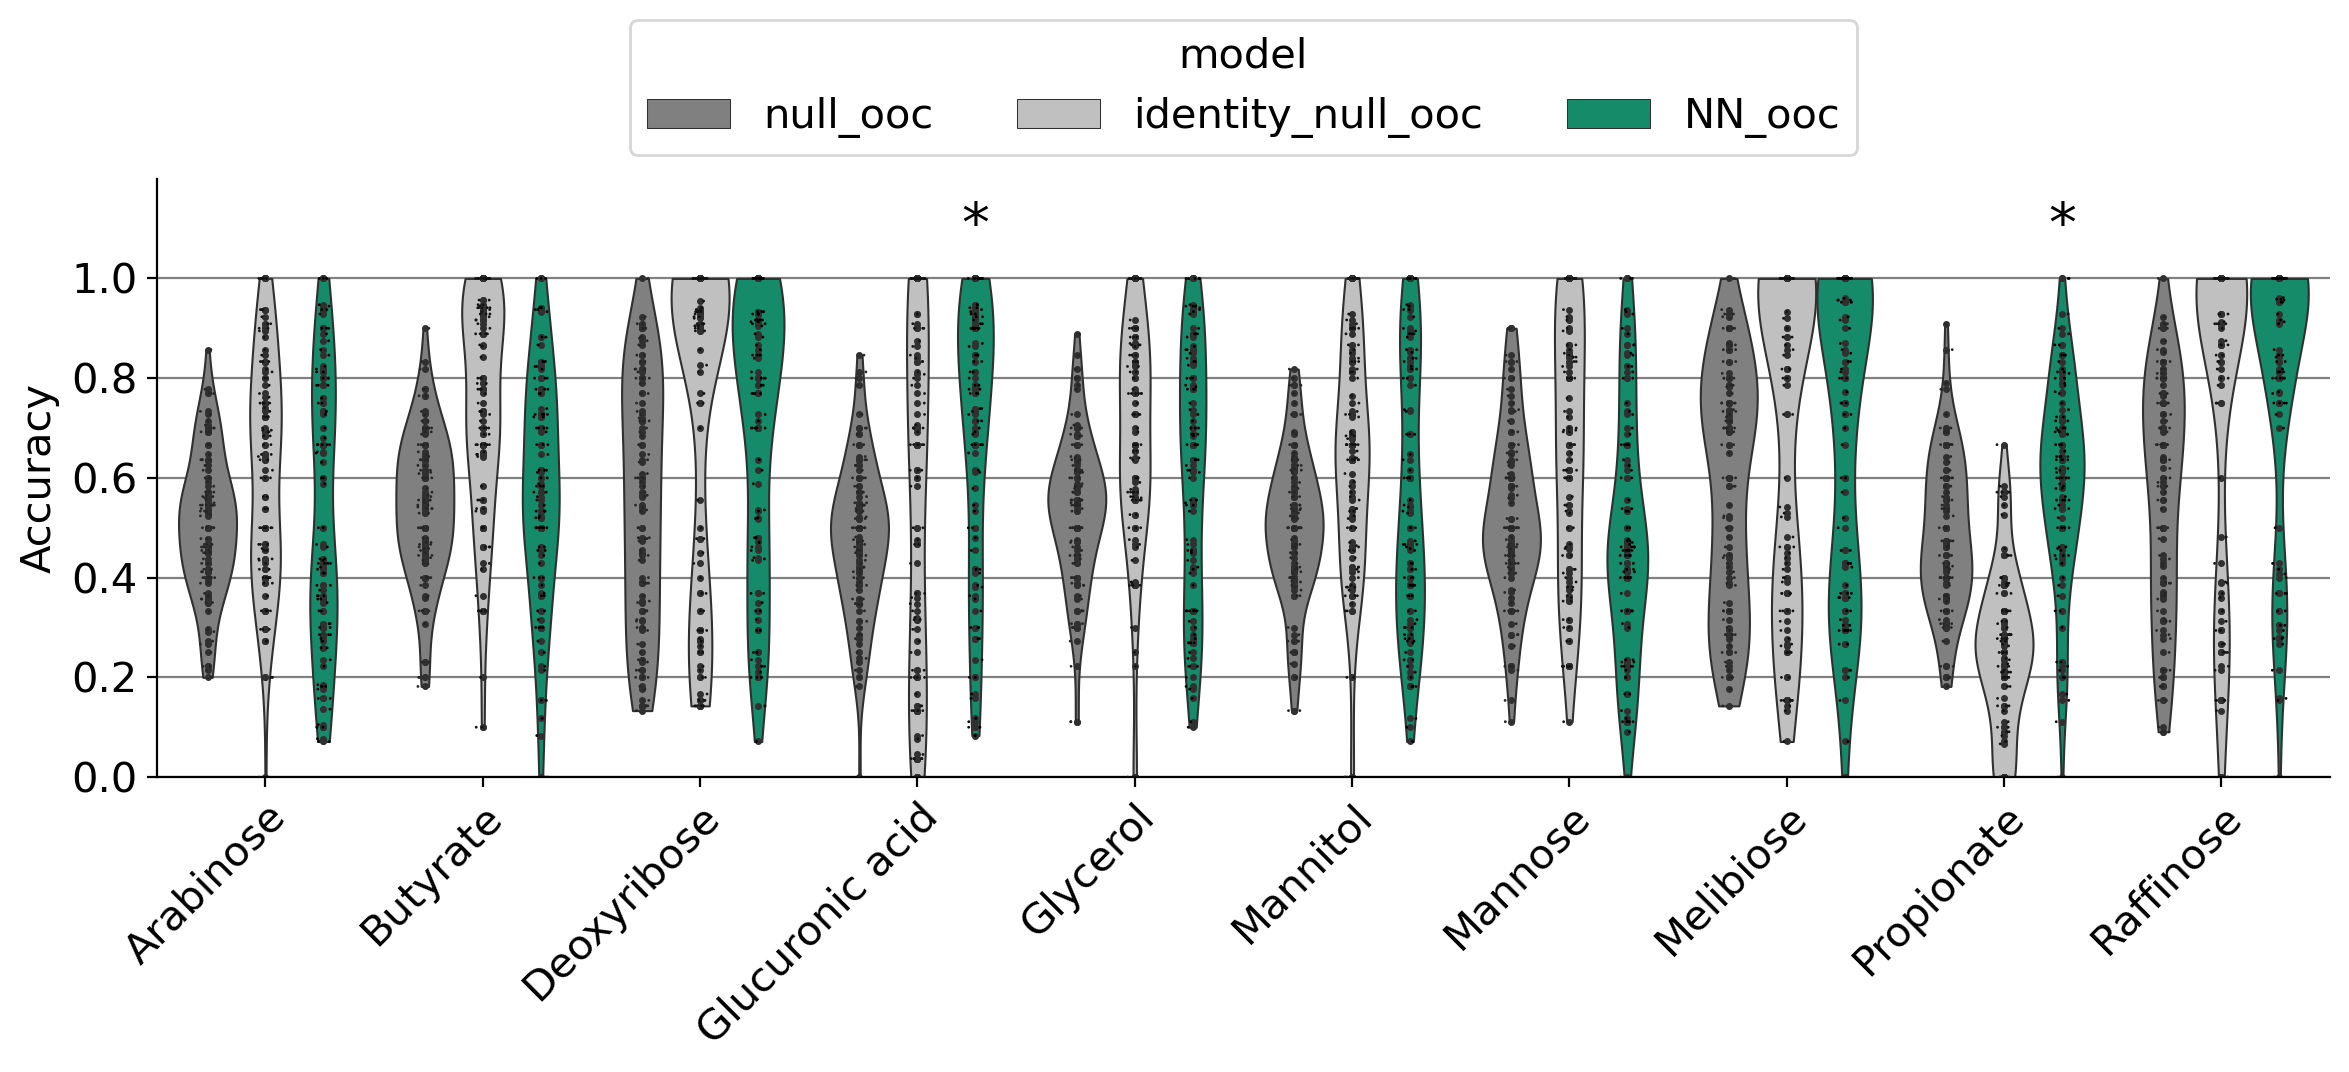

In [27]:
hue_order=['null', 'identity_null','fba', 'NN', 'null_ooc','identity_null_ooc','NN_ooc']

fig1, stats=plot_fancy_model_comparison(results_all, hue_order=['null', 'identity_null','fba', 'NN'],stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=3,rotate_x=True, 
            single_annotation=True, show_null_model=True, pair_annotation=False, )

fig2, stats=plot_fancy_model_comparison(results_all, hue_order=['null_ooc','identity_null_ooc','NN_ooc'],stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=3,rotate_x=True, colors={'NN_ooc':COLORS[2]},
            single_annotation=True, show_null_model=True, pair_annotation=False, )

# disable fig 1 x labels
# fig1.gca().set_xticklabels([])

for fig in [fig1, fig2]:
    # fig.gca().set_title(f"Zeqian data")
    fig.gca().set_ylabel('Accuracy')
    fig.gca().set_xlabel(None)


## 2B: Phylogeny - trait correlation plot

See figure_2B.ipynb 

# Figure 3

## Models 

In [6]:
threads=48
p=None
#p=Pool(threads)

In [7]:
DIR_figure=f"{DIR_data}/figure_data/3A"


models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'nce_fs_ooc':[NCEFeatureSelection,
                {'model_params':{
                    "Model":RF, 
                    "model_params":{'n_estimators':100,'max_features':None},
                    "keep_top": 5,
                    "max_features":5, 
                    "n_feature_subsample":None,
                    "threads":threads, 'p':p,               
                    "save_feature_selection_data":100,
                    'verbose':False, 
                    },
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads':1,
                'p': None,
                'save_models':True,
                }],
        'GreedyFeatureSelection_ooc':[GreedyFeatureSelection,
                {'model_params':{
                    "Model":DecisionTree, 
                    'tree':zeqian['tree'],
                    "model_params":{},
                    "n_max_features":3, 
                    "n_feature_subsample":None,
                    "n_meta_split":10, 
                    "split_method":'ooc',
                    "splitter_params":{'test_set_range':(0.1,0.3),'min_zeros':0,'min_ones':0,'time_out_iter':None},
                    "threads":threads,                    
                    "save_meta_models":False,
                    'verbose':False,
                    'p':p,},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':10,
                'threads':1,
                'save_models':False,
                }]
}

matrices={
          'zeqian_genome': zeqian
        }


In [23]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_genome identity_null
Already exists. Skipping. 
Running zeqian_genome identity_null_ooc
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 
Running zeqian_genome RF
Already exists. Skipping. 
Running zeqian_genome RF_ooc
Already exists. Skipping. 
Running zeqian_genome nce_fs_ooc
Already exists. Skipping. 
Running zeqian_genome GreedyFeatureSelection_ooc
Already exists. Skipping. 
Running models done.
Concatenating data...
Concatenating data done.


In [9]:
def load_cache(ff):
    res=[]
    with open(ff, 'rb') as f:
        while True:
            try:
                res.extend(pickle.load(f))
            except EOFError:
                break
    return pd.DataFrame(res)

res1=load_cache("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/cache/zeqian_genome_GreedyFeatureSelection_ooc.pk")
res2=load_cache("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/cache/zeqian_genome_GreedyFeatureSelection_ooc_0.pk")
res3=load_cache("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/cache/zeqian_genome_GreedyFeatureSelection_ooc_1.pk")
res4=load_cache("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/cache/zeqian_genome_GreedyFeatureSelection_ooc_2.pk")


In [16]:
res=pd.concat([res1[res1['carbon_name'].isin(['Arabinose','Butyrate','Deoxyribose','Glucuronic acid','Glycerol','Mannitol'])],res4,res3[res3['carbon_name'].isin(['Melibiose','Propionate','Raffinose'])]], axis=0)

In [19]:
res.to_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/results/zeqian_genome_GreedyFeatureSelection_ooc.pk")

In [28]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/results_all.pk")

# results_all['model']=results_all['model'].replace({'GreedyFeatureSelection':'GreedyFeatureSelection_ooc'})

In [29]:
model_pairs=[('NN', 'null'), ('NN_ooc', 'null_ooc'), ('RF', 'null'), ('RF_ooc', 'null_ooc'), ('GreedyFeatureSelection_ooc', 'null_ooc'), ('nce_fs_ooc','null_ooc'),
            ('NN','identity_null'), ('NN_ooc','identity_null_ooc'), ('RF','identity_null'), ('RF_ooc','identity_null_ooc'), ('GreedyFeatureSelection_ooc','identity_null_ooc'),('nce_fs_ooc','identity_null_ooc')]
hue_order=['null', 'identity_null','RF', 'NN', 'null_ooc', 'identity_null_ooc','RF_ooc','NN_ooc','nce_fs_ooc','GreedyFeatureSelection_ooc']
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [01:37<00:00,  9.72s/it]


['null', 'identity_null']


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


['null_ooc', 'identity_null_ooc']


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


['null_ooc', 'identity_null_ooc']


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


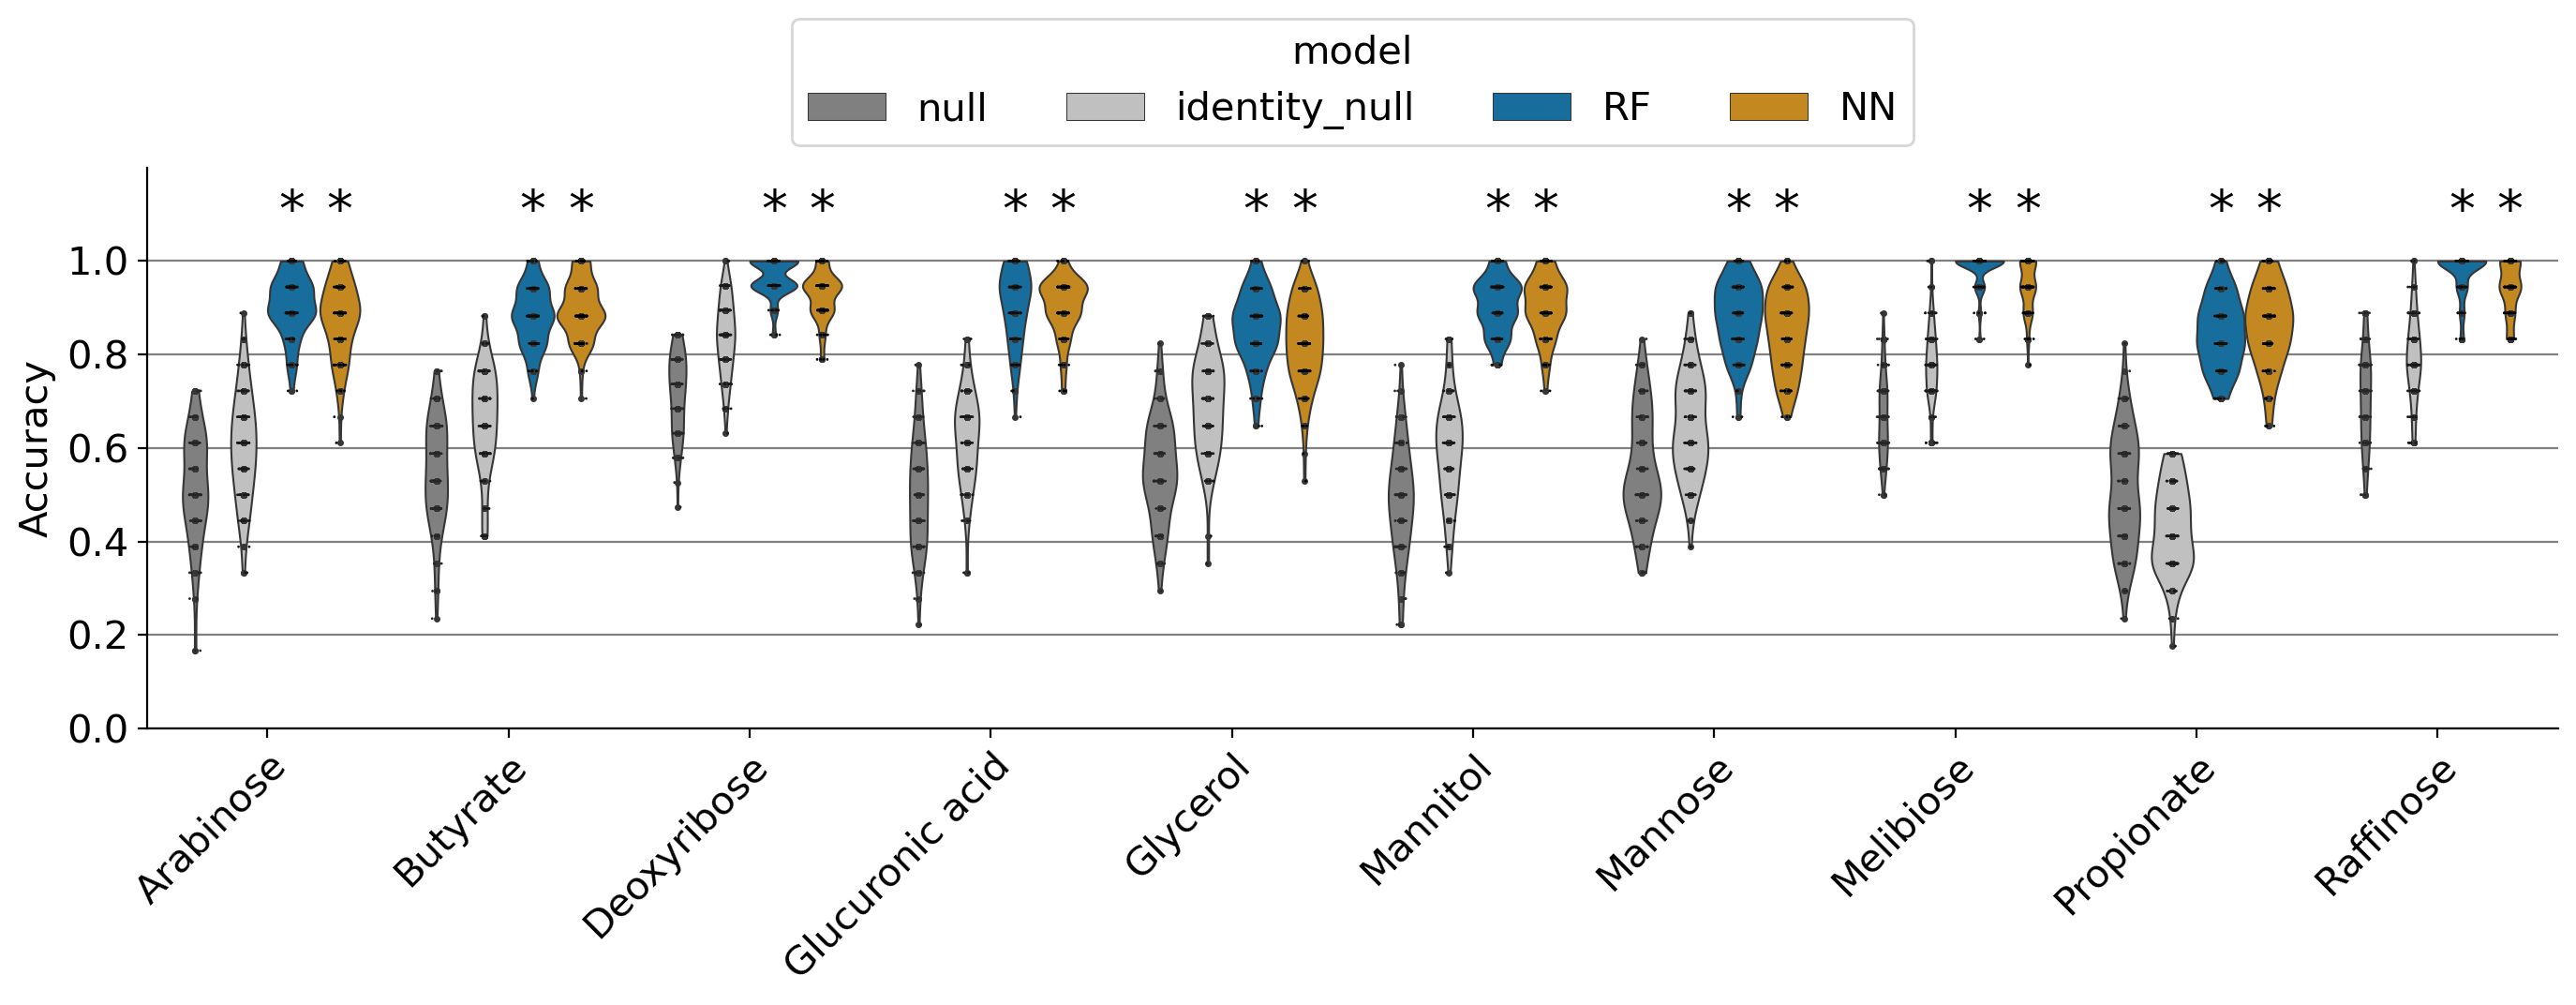

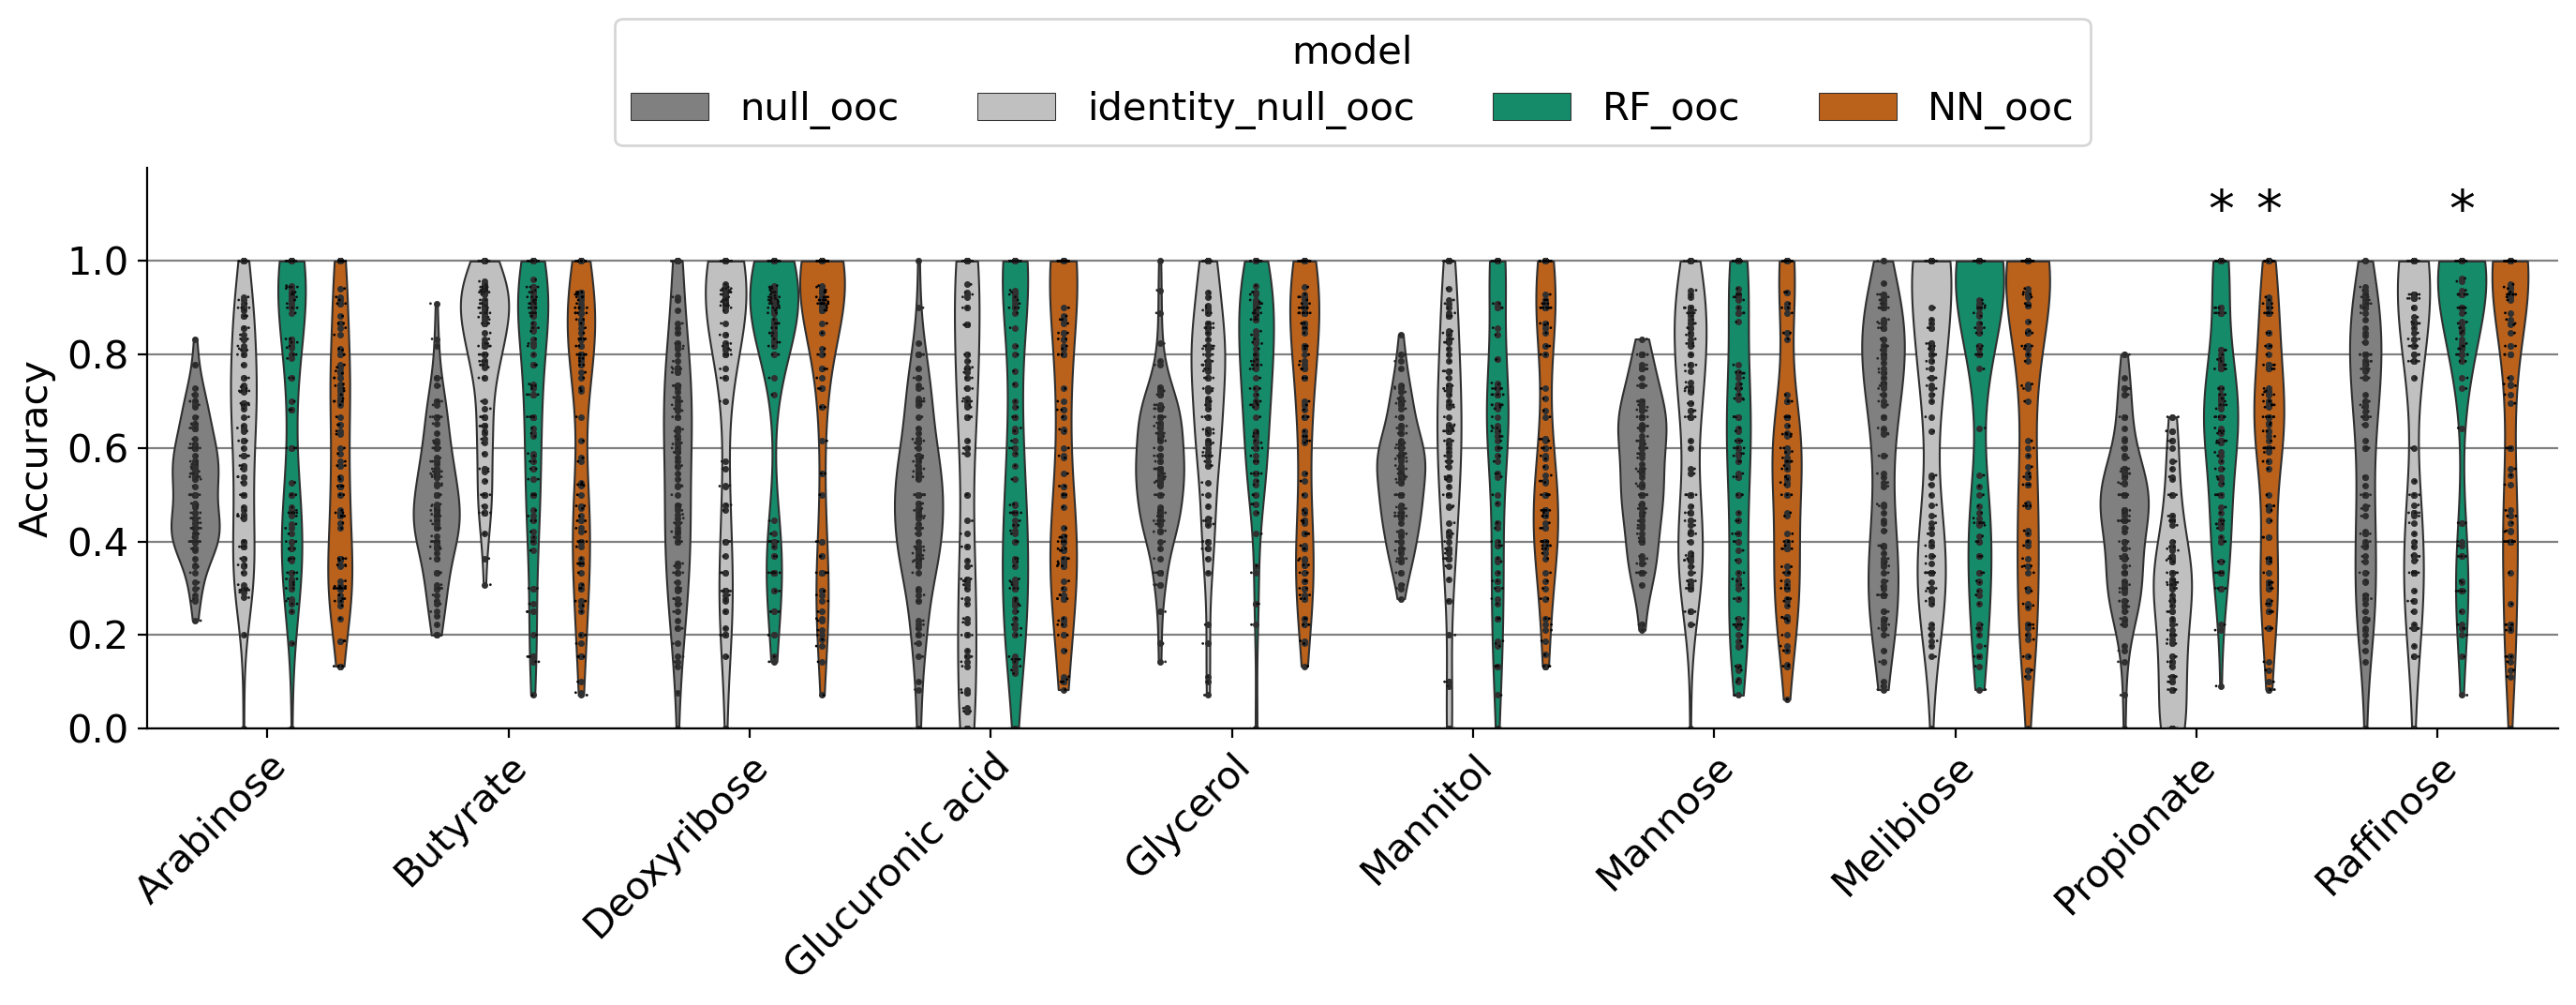

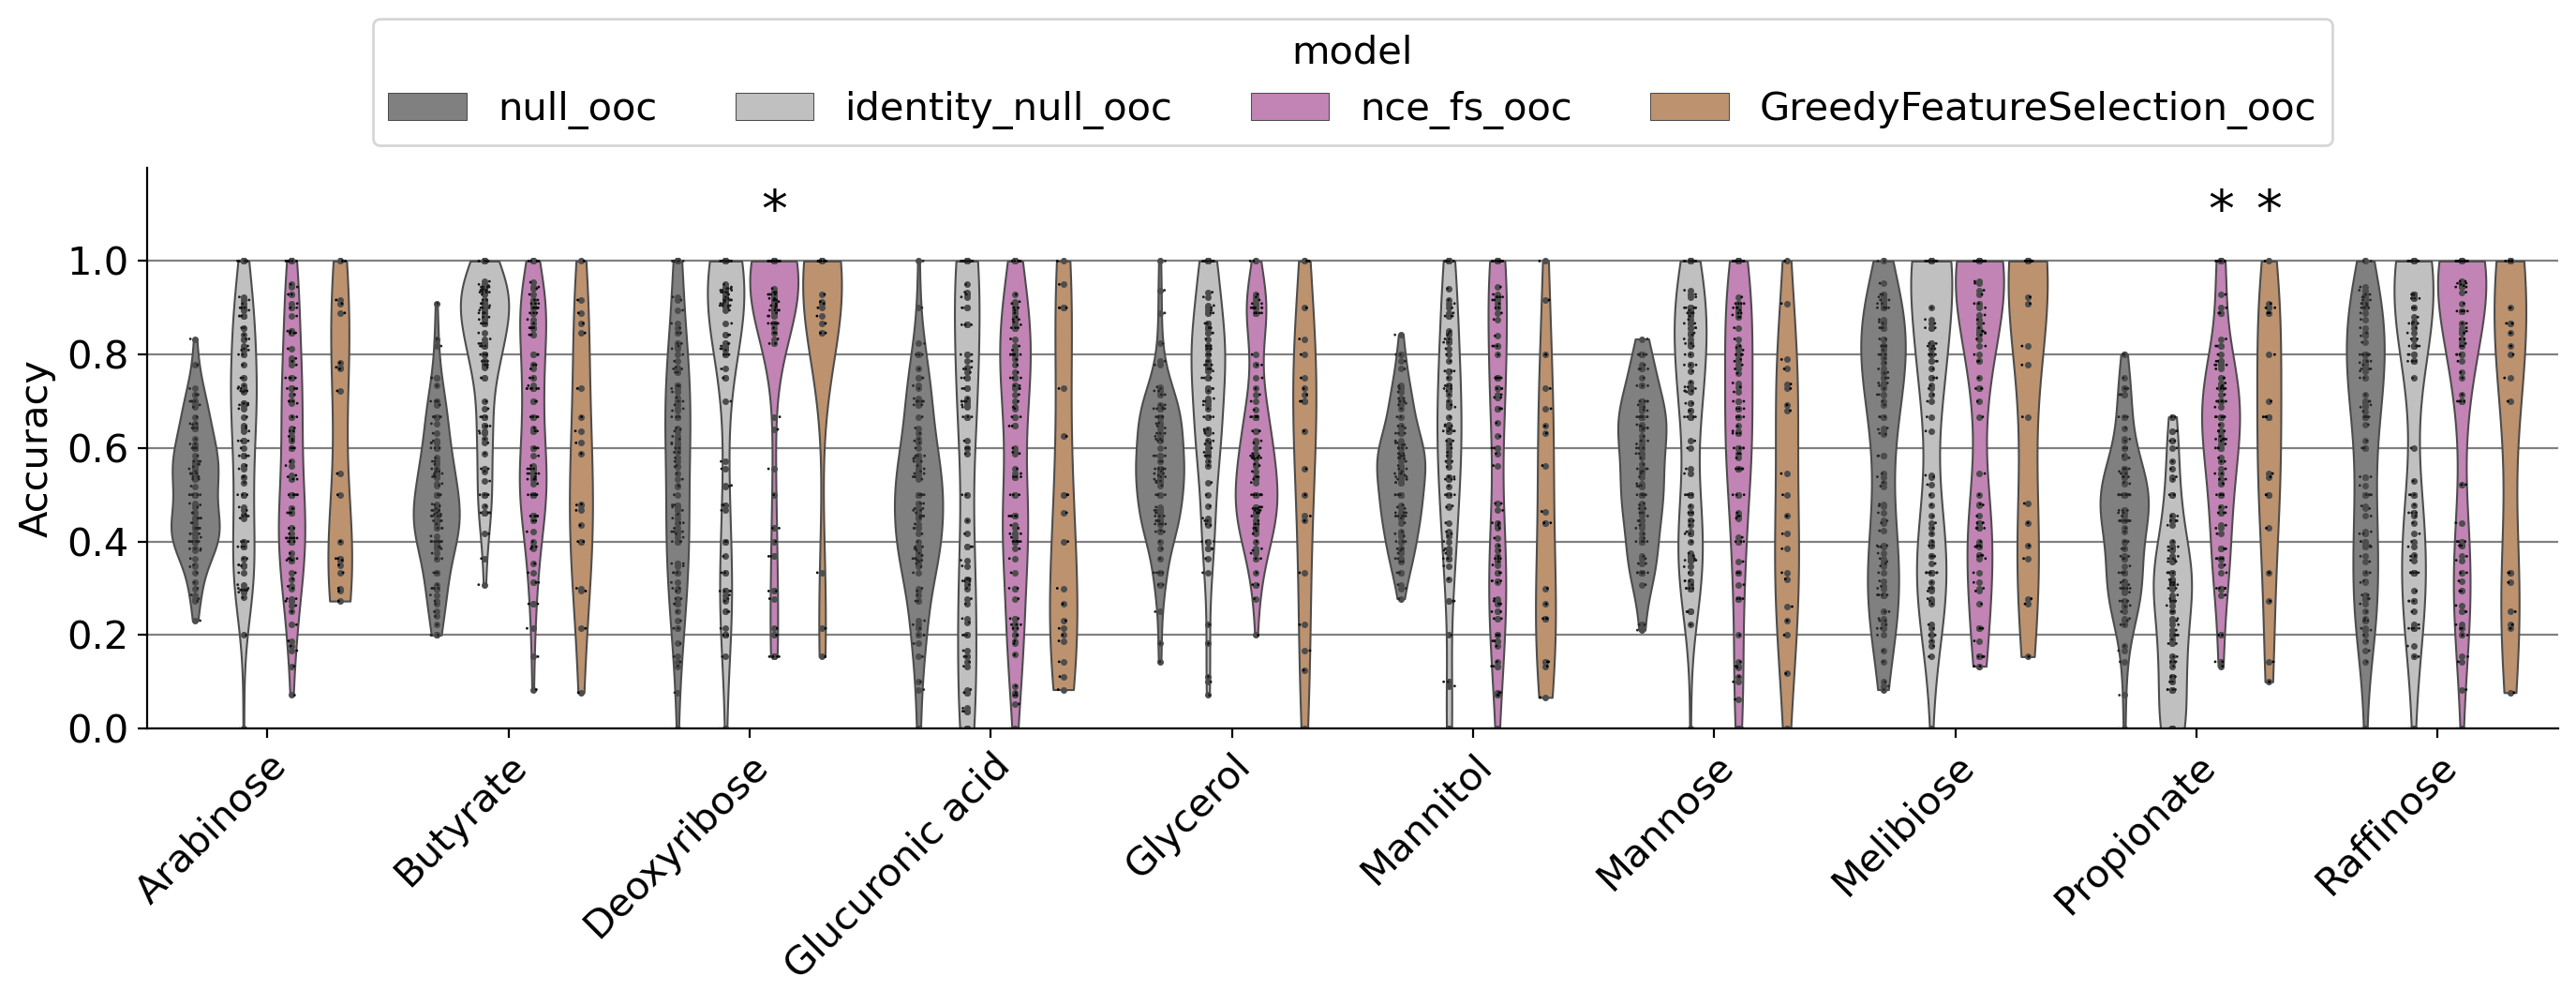

In [33]:
hue_orders_1=['null', 'identity_null','RF', 'NN']
hue_orders_2=['null_ooc', 'identity_null_ooc','RF_ooc','NN_ooc']
hue_orders_3=['null_ooc', 'identity_null_ooc','nce_fs_ooc','GreedyFeatureSelection_ooc']

fig1, stats=plot_fancy_model_comparison(results_all, hue_order=hue_orders_1,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=3.5,single_annotation=True, show_null_model=True, pair_annotation=False, colors={'RF':COLORS[0], 'NN':COLORS[1]})
fig2, stats=plot_fancy_model_comparison(results_all, hue_order=hue_orders_2,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=3.5,single_annotation=True, show_null_model=True, pair_annotation=False, colors={'RF_ooc':COLORS[2], 'NN_ooc':COLORS[3]})
fig3, stats=plot_fancy_model_comparison(results_all, hue_order=hue_orders_3,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=3.5,single_annotation=True, show_null_model=True, pair_annotation=False, colors={'nce_fs_ooc':COLORS[4], 'GreedyFeatureSelection_ooc':COLORS[5]})

for fig in [fig1,fig2,fig3]:
    fig.gca().set_ylabel('Accuracy')
    fig.gca().set_xlabel(None)
    # fig.gca().set_xticklabels(fig.gca().get_xticklabels(), rotation=45, ha='right')

    #plt.xlabel(None)


## Feature importance

In [8]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/results_all.pk")

carbon_kos=[]
DIR_kegg_pathway="/home/zeqianli/project/zeqian/Carbon/data/kegg/pathways"
for pathway in os.listdir(DIR_kegg_pathway):
    carbon_kos.extend(pd.read_csv(os.path.join(DIR_kegg_pathway,pathway,'kos.txt'),sep='\t',header=None).values)
carbon_kos=np.unique(carbon_kos)

df_kegg=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")
highlight_keys=['by_pathway','by_k3_path_directed','by_reaction']
highlight_dict={}
for c, row in df_kegg.iterrows():
    highlight_dict[c]={'carbon_metabolism': carbon_kos}
    for key in highlight_keys:
        highlight_dict[c][key]=row[key]



/home/zeqianli/ipykernel_44314/163737558.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Mean feature importance')

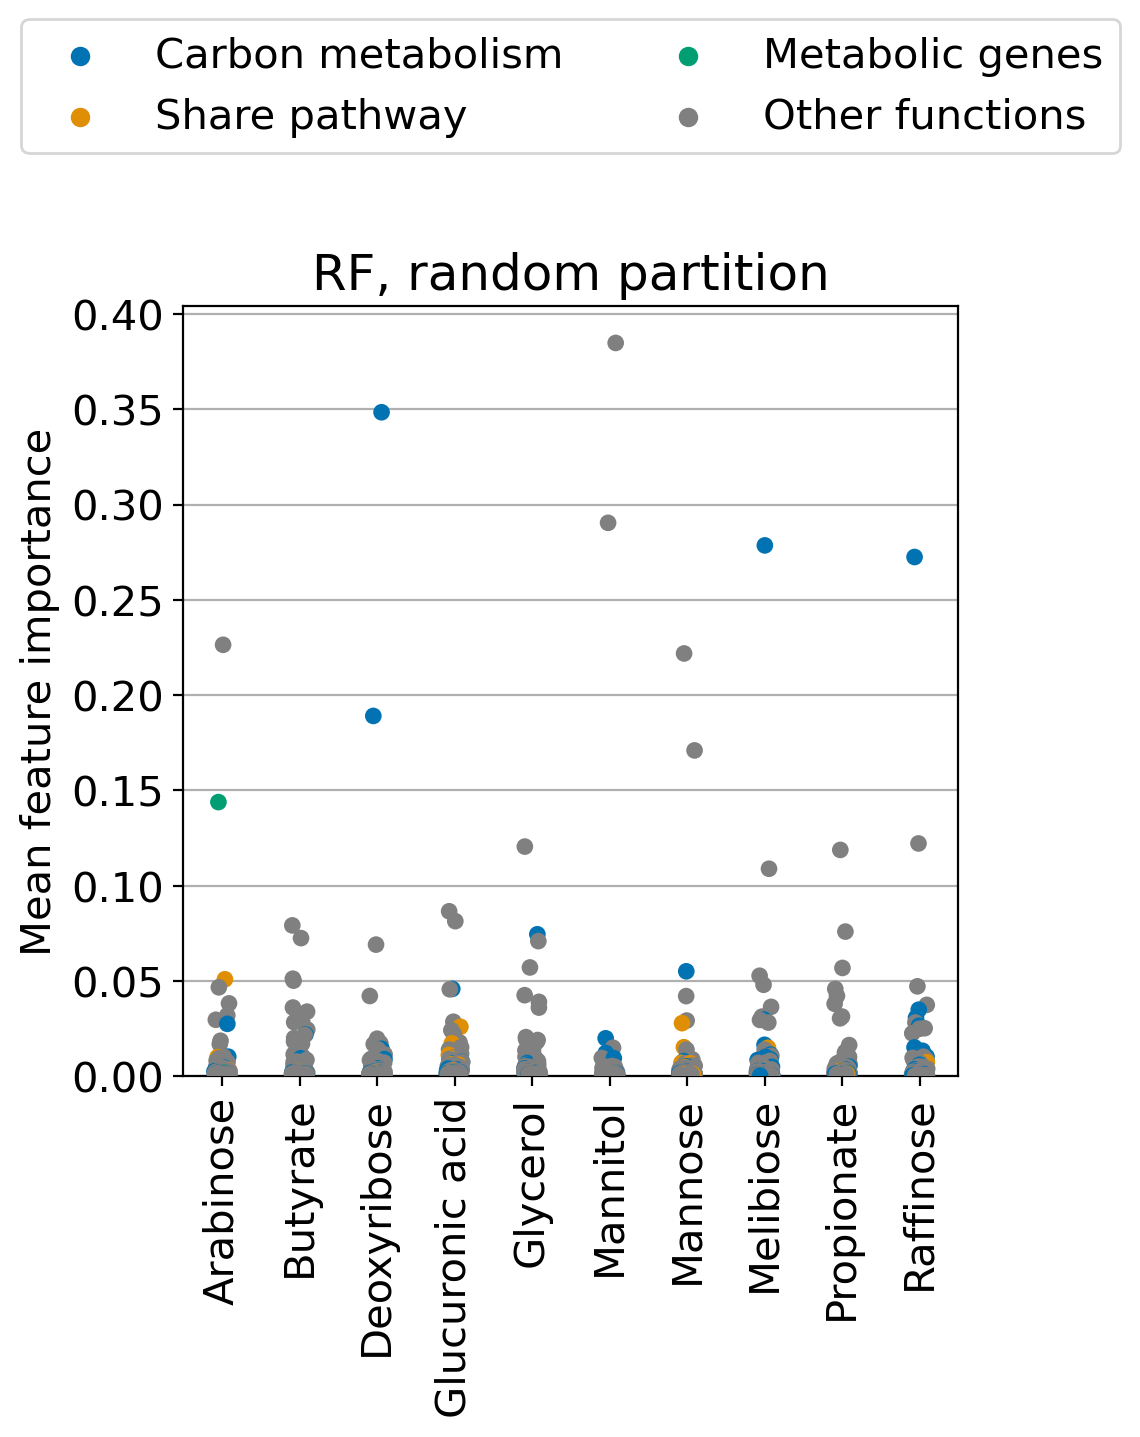

In [23]:
fi=cal_feature_importance(results_all[results_all['model']=='RF'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
fi['highlight']=fi['highlight'].map({'':'Other functions','carbon_metabolism': 'Carbon metabolism', 'by_pathway': "Share pathway", 'by_k3_path_directed': "Metabolic genes"})
colors={'Other functions':'grey','Carbon metabolism':COLORS[0], 'Share pathway':COLORS[1], 'Metabolic genes':COLORS[2]}

plt.figure(figsize=(5,5))
sns.stripplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',palette=colors, hue_order=['Carbon metabolism','Share pathway','Metabolic genes','Other functions'], s=6)


# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),ncol=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("RF, random partition")

# y grid 
ax.yaxis.grid(True)

plt.xlabel(None)
plt.ylabel("Mean feature importance")



/home/zeqianli/ipykernel_44314/3973210048.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Mean feature importance')

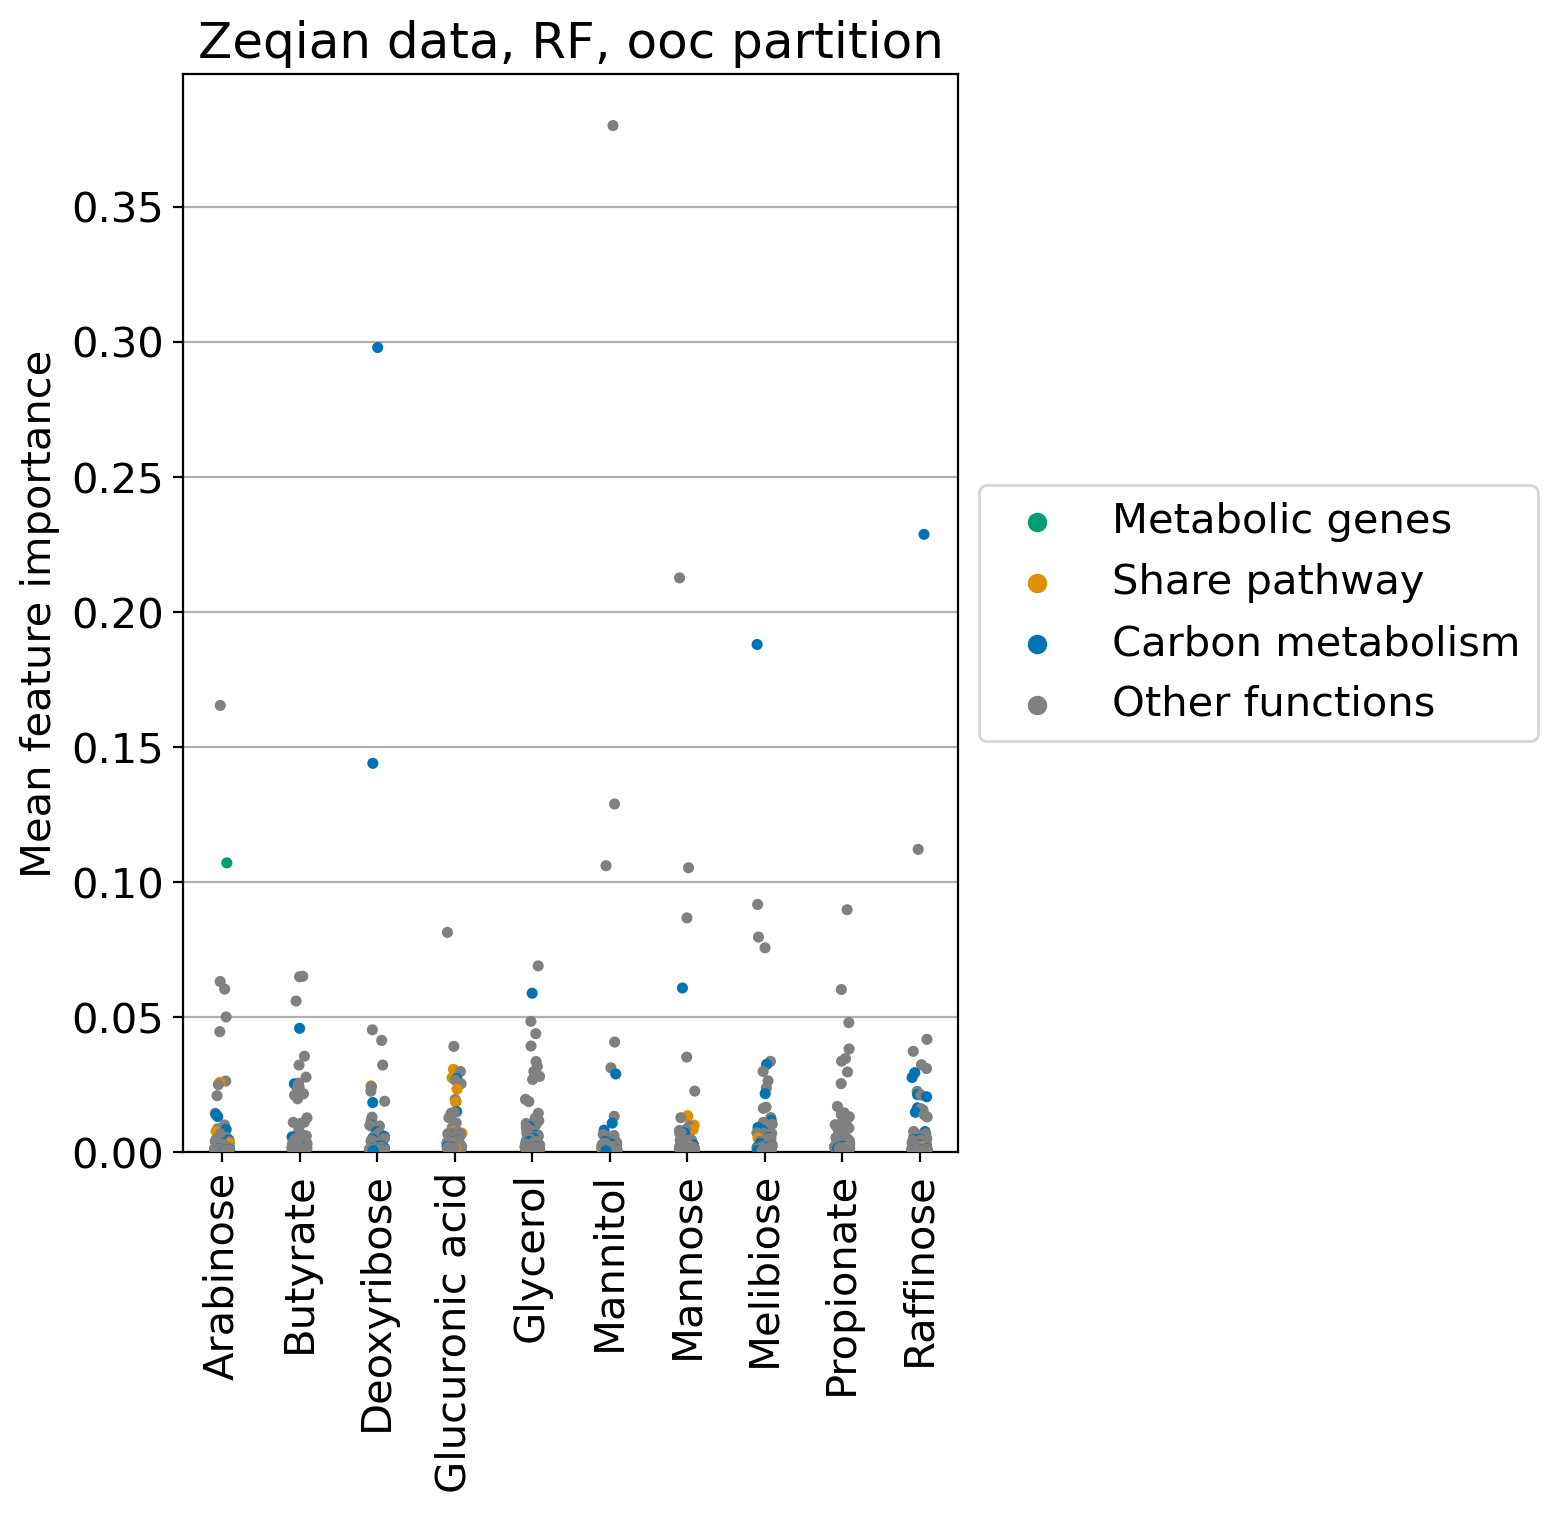

In [10]:
fi=cal_feature_importance(results_all[results_all['model']=='RF_ooc'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
fi['highlight']=fi['highlight'].map({'':'Other functions','carbon_metabolism': 'Carbon metabolism', 'by_pathway': "Share pathway", 'by_k3_path_directed': "Metabolic genes"})
colors={'Other functions':'grey','Carbon metabolism':COLORS[0], 'Share pathway':COLORS[1], 'Metabolic genes':COLORS[2]}

plt.figure(figsize=(5,7))
sns.stripplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',palette=colors, hue_order=['Metabolic genes','Share pathway','Carbon metabolism','Other functions'], s=4)


# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Zeqian data, RF, ooc partition")

# y grid 
ax.yaxis.grid(True)

plt.xlabel(None)
plt.ylabel("Mean feature importance")

In [7]:
fi[fi['carbon_name']=='Propionate']

,index,features,carbon_name,fi_mean,fi_std,highlight
800,3698,K09007,Propionate,0.010019,0.008661,Other functions
801,4661,K13489,Propionate,0.007344,0.006775,Other functions
802,4280,K11444,Propionate,0.007032,0.006829,Other functions
803,3741,K09165,Propionate,0.005765,0.006168,Other functions
804,4659,K13487,Propionate,0.005752,0.006100,Other functions
...,...,...,...,...,...,...
895,1874,K03394,Propionate,0.001620,0.002593,Other functions
896,2404,K04719,Propionate,0.001612,0.002660,Other functions
897,1916,K03464,Propionate,0.001590,0.002539,Other functions
898,587,K01054,Propionate,0.001584,0.002821,Other functions


# Figure 4

## 4 cartoon: synthetic traits

In [27]:
bacdive['ko_data'].iloc[:100,:200]

,K00001,K00003,K00012,K00013,K00014,K00015,K00024,K00031,K00033,K00034,K00036,K00052,K00053,K00057,K00058,K00059,K00060,K00064,K00065,K00067,K00077,K00088,K00097,K00099,K00104,K00111,K00117,K00128,K00133,K00134,K00135,K00145,K00147,K00156,K00161,K00162,K00164,K00174,K00175,K00184,K00185,K00209,K00215,K00239,K00240,K00241,K00254,K00259,K00261,K00265,K00274,K00275,K00278,K00281,K00286,K00287,K00290,K00297,K00299,K00316,K00324,K00325,K00330,K00331,K00332,K00333,K00335,K00336,K00337,K00338,K00339,K00340,K00341,K00342,K00343,K00344,K00362,K00366,K00368,K00372,K00380,K00381,K00382,K00384,K00389,K00390,K00404,K00405,K00406,K00428,K00493,K00507,K00520,K00525,K00526,K00537,K00548,K00549,K00554,K00560,K00566,K00567,K00568,K00574,K00575,K00587,K00598,K00600,K00602,K00604,K00605,K00606,K00609,K00611,K00615,K00616,K00620,K00625,K00626,K00627,K00639,K00640,K00645,K00647,K00648,K00652,K00655,K00657,K00658,K00661,K00663,K00666,K00675,K00677,K00681,K00684,K00688,K00700,K00703,K00705,K00720,K00721,K00748,K00754,K00759,K00760,K00761,K00762,K00763,K00764,K00765,K00766,K00767,K00773,K00782,K00783,K00786,K00788,K00789,K00790,K00791,K00793,K00794,K00796,K00797,K00799,K00800,K00801,K00806,K00809,K00812,K00817,K00819,K00820,K00821,K00826,K00830,K00833,K00845,K00847,K00848,K00850,K00851,K00852,K00853,K00854,K00858,K00859,K00860,K00864,K00865,K00872,K00873,K00874,K00882,K00891,K00912,K00919,K00925,K00927
10173,2,1,3,1,4,1,1,1,3,1,3,1,1,2,2,7,1,0,0,1,1,2,0,1,3,5,0,3,1,1,3,1,1,2,3,4,1,1,1,0,0,0,1,2,2,1,0,2,0,1,0,1,1,1,1,1,1,1,3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,0,1,0,0,0,0,4,3,1,1,0,0,0,0,3,0,0,1,0,0,1,0,1,1,1,4,0,3,0,0,1,1,1,1,1,1,1,2,4,2,1,0,5,5,1,2,1,1,3,0,5,0,2,0,1,3,0,0,2,0,2,1,0,1,0,3,0,0,1,2,1,1,1,1,1,1,1,1,4,1,1,2,1,1,1,1,1,2,0,1,2,0,2,0,3,2,1,1,1,1,0,0,3,1,0,2,1,1,0,5,1,1,1,5,1,1,2,2,1,1,0,1,1,1
10174,6,1,1,1,1,1,1,1,2,0,3,1,1,1,5,8,1,1,0,2,2,2,0,1,2,1,0,6,1,1,1,1,1,2,4,3,0,0,0,0,0,0,1,2,2,1,0,1,0,1,0,1,1,1,1,0,0,1,3,0,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,7,0,0,2,0,0,0,3,3,2,0,0,0,0,0,1,1,1,2,1,0,1,1,1,1,1,7,0,3,0,0,1,1,1,1,1,0,1,1,1,1,1,0,10,3,1,1,1,0,2,0,4,1,1,0,0,9,0,0,5,0,1,1,0,0,0,1,0,0,1,2,1,1,1,1,1,1,1,1,0,0,0,0,1,2,1,1,1,2,1,1,1,0,2,0,4,2,1,2,1,1,0,0,7,1,1,0,2,1,1,5,1,1,0,1,1,1,1,1,2,1,0,1,1,1
10430,0,1,2,1,1,0,1,1,0,0,0,1,1,1,1,2,0,0,0,0,1,1,1,1,1,0,0,1,1,2,0,1,1,0,1,1,0,1,1,0,1,0,1,3,3,2,1,0,0,1,0,0,0,0,1,0,2,1,0,0,0,0,1,1,0,2,0,0,2,1,1,1,1,2,1,0,0,0,0,0,0,0,1,2,0,0,0,0,0,2,0,0,0,1,1,0,0,1,1,1,2,0,0,0,0,0,0,1,1,1,0,1,1,1,2,0,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,2,1,1,1,0,2,1,1,1,1,1,1,1,0,0,0,1,0,1,2,0,1,2,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1,0,1
10433,0,1,0,1,2,0,0,1,1,0,1,1,1,1,0,2,0,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,1,1,1,1,2,1,1,1,1,1,1,1,1,0,0,0,1,0,2,1,4,1,0,1,1,1,1,1,0,0,0,1,1,2,0,2,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,0,3,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,2,2,1,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,1,1,0,1,1,1,0,0,1,0,1,0,0,1,1,1,1,1
10434,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,2,0,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,4,1,0,1,1,1,1,0,0,0,0,1,1,1,0,2,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,0,1,0,3,0,1,0,0,0,0,1,0,1,1,1,1,0,0,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,2,0,1,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
zeqian

<AxesSubplot: >

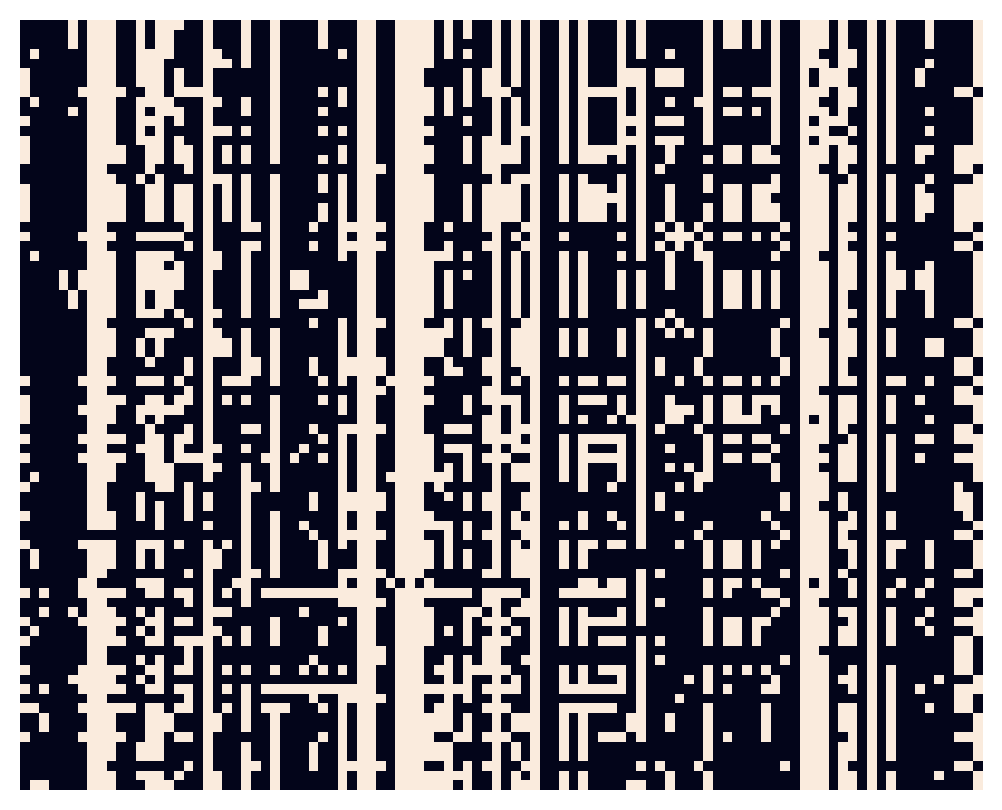

In [35]:
ko_data=(matti['ko_data']>0).astype(int)
sns.heatmap(ko_data.iloc[:80,:100],square=True,cbar=False,xticklabels=False,yticklabels=False)

<AxesSubplot: >

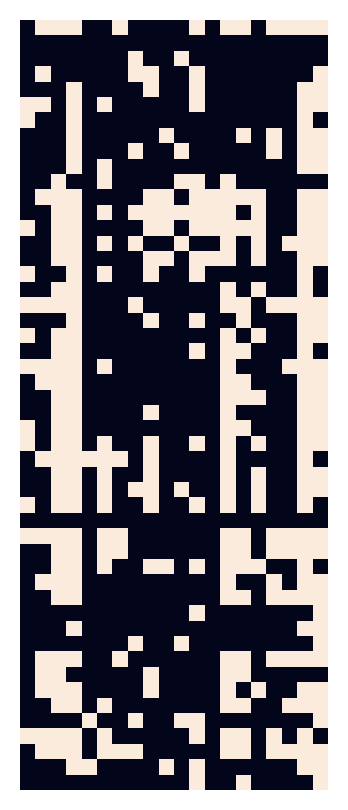

In [41]:
sns.heatmap((pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/synthetic_data/100_100_3_0.3.pk")['growth_data'].iloc[:50,:20]>0).astype(int),square=True,cbar=False,xticklabels=False,yticklabels=False)

## 4A: Synthetic data phase space

See figure_3b.ipynb

## 4B: bacdive data

In [4]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive"

### Run models

In [6]:
threads=48

models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'identity_null': [IdentityNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],
        'identity_null_ooc': [IdentityNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': 1,
                 'save_models':False
                 }],

        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        
}

datasets={'bacdive': bacdive}

In [8]:
#p=Pool(threads)
p=None

In [ ]:
results_all=run_multiple_models(models, datasets, DIR_figure, 
                    p=p)

Running models...
Running bacdive null


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [05:52<00:00, 16.46it/s]


Finished bacdive null 
Running bacdive null_ooc


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [05:45<00:00, 16.77it/s]


Finished bacdive null_ooc 
Running bacdive identity_null


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [00:52<00:00, 110.58it/s]


Finished bacdive identity_null 
Running bacdive identity_null_ooc


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [00:52<00:00, 111.23it/s]


Finished bacdive identity_null_ooc 
Running bacdive NN


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [06:31<00:00, 14.82it/s]


Finished bacdive NN 
Running bacdive NN_ooc


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5800/5800 [06:30<00:00, 14.86it/s]


Finished bacdive NN_ooc 
Running bacdive RF


Training models...:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5504/5800 [1:20:39<00:01, 175.41it/s]

### Accuracies of all carbons

In [4]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive/results_all.pk")

In [10]:
results_all

/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,carbon_name,train_samples,test_samples,is_null_model,null_model,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,model,dataset_name,identity_null_pred,n_neighbors,weights,metric,feature_importances
0,3-hydroxybutyrate,"[10773, 11062, 11264, 11335, 11861, 11862, 121...","[13155, 131560, 13169, 13189, 133018, 135100, ...",True,bernoulli,2,2,10,13,0.555556,0.866667,0.565217,0.500000,0.684211,0.532609,111,27,null,bacdive,NaN,NaN,NaN,NaN,NaN
1,3-hydroxybutyrate,"[10773, 11062, 11335, 11862, 1219, 1221, 13062...","[11264, 11861, 1220, 131560, 133078, 135100, 1...",True,bernoulli,3,3,6,15,0.666667,0.833333,0.714286,0.500000,0.769231,0.607143,111,27,null,bacdive,NaN,NaN,NaN,NaN,NaN
2,3-hydroxybutyrate,"[11062, 11264, 11335, 11862, 1219, 1220, 1221,...","[10773, 11861, 13189, 133320, 140306, 140383, ...",True,bernoulli,5,5,6,11,0.592593,0.687500,0.647059,0.500000,0.666667,0.573529,111,27,null,bacdive,NaN,NaN,NaN,NaN,NaN
3,3-hydroxybutyrate,"[11062, 11264, 11335, 11861, 1219, 1220, 1221,...","[10773, 11862, 131560, 13189, 133144, 134197, ...",True,bernoulli,4,3,5,15,0.703704,0.833333,0.750000,0.571429,0.789474,0.660714,111,27,null,bacdive,NaN,NaN,NaN,NaN,NaN
4,3-hydroxybutyrate,"[10773, 11335, 11861, 1219, 1220, 130623, 1306...","[11062, 11264, 11862, 1221, 13169, 133018, 140...",True,bernoulli,3,5,8,11,0.518519,0.687500,0.578947,0.375000,0.628571,0.476974,111,27,null,bacdive,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46395,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11861, 11862, 11894, 1219, 1220, 1221, 130529...",NaN,NaN,0,12,1,87,0.870000,0.878788,0.988636,0.000000,0.930481,0.494318,637,100,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0005459101862842669, 0.0, 0.0, 0...."
46396,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11215, 11218, 11222, 11234, 11235, 11236, 112...",NaN,NaN,0,11,1,68,0.850000,0.860759,0.985507,0.000000,0.918919,0.492754,657,80,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.00010527327789261163, 0.0, 0.0, 0.0, 0.0, 0..."
46397,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11946, 12498, 12501, 12502, 12538, 12543, 125...",NaN,NaN,4,3,12,79,0.846939,0.963415,0.868132,0.571429,0.913295,0.719780,639,98,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0011402161904290513, 0.0, 0.0, 0...."
46398,xylose,"[10615, 10802, 10803, 11033, 11043, 11062, 110...","[11959, 1218, 1219, 1220, 1221, 1240, 1255, 12...",NaN,NaN,0,6,0,78,0.928571,0.928571,1.000000,0.000000,0.962963,0.500000,653,84,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 8.783965563626579e-0..."


In [12]:
# results_all=results_all[results_all['dataset_name']=='matti_16s']

model_pairs=[('RF_ooc', 'identity_null_ooc'), ('RF_ooc', 'null_ooc')]
stats=compare_models(results_all, 
                    model_pairs=[(*model_pair, ttest_permutation) for model_pair in model_pairs],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction='hs',correct_by='carbons').set_index('carbon_name')

100%|██████████| 58/58 [01:32<00:00,  1.60s/it]

Correcting p-values...


In [13]:
stats['significant']=((stats['RF_ooc_identity_null_ooc_p']<0.05) & (stats['RF_ooc_null_ooc_p']<0.05) & (stats['RF_ooc_identity_null_ooc_t']>0) & (stats['RF_ooc_null_ooc_t']>0))
stats[stats['significant']]

stat,RF_ooc_identity_null_ooc_p,RF_ooc_identity_null_ooc_t,RF_ooc_null_ooc_p,RF_ooc_null_ooc_t,significant
carbon_name,,,,,
3-hydroxybutyrate,0.00053,3.400713,0.00002,14.811997,True
tryptophan,0.00002,9.588697,0.00002,21.972970,True


Two carbons are significant: myo-inositol and tryptophan. The former has low prediction accuracy, ranging in 0.5-0.8 (also for random partition). 

### Feature importance

/home/zeqianli/ipykernel_1520939/1500317932.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Tryptophan'])


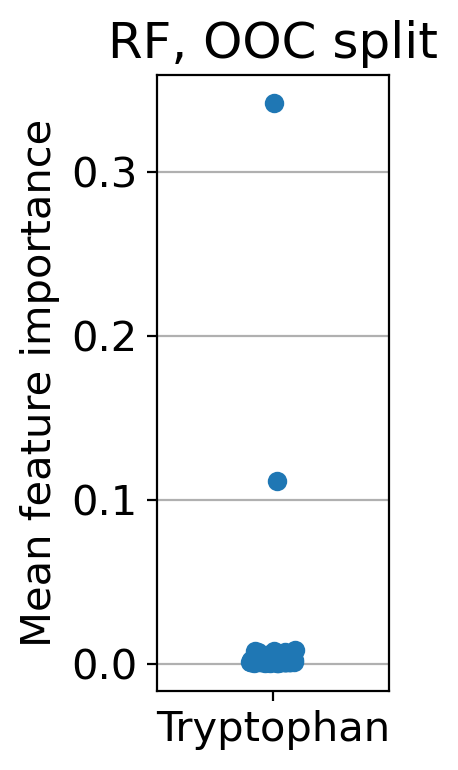

In [21]:
fi=cal_feature_importance(results_all[(results_all['carbon_name']=='tryptophan') & (results_all['model']=='RF_ooc')], bacdive['ko_data'])

fig=plt.figure(figsize=(1.5,4))
sns.stripplot(data=fi, x='carbon_name', y='fi_mean',s=7)

plt.ylabel("Mean feature importance")
plt.xlabel(None)
plt.gca().set_xticklabels(['Tryptophan'])
plt.title("RF, OOC split")
plt.gca().yaxis.grid(True)


### Remove RNF genes from predictors

In [15]:
threads=48
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf"


from scipy.stats import pearsonr
rs={ko: pearsonr(bacdive['ko_data'][ko], bacdive['ko_data']['K03612'])[0] for ko in tqdm(bacdive['ko_data'].columns.values)}
rs=pd.Series(rs).abs().sort_values(ascending=False)
correlated_genes=rs[rs>0.5].index.values

models={
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':True
                }],
        
}

datasets={#'bacdive': {'ko_data': bacdive['ko_data'], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
          'bacdive_no_rnf': {'ko_data': bacdive['ko_data'].drop(columns=correlated_genes), 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
         'bacdive_only_tnaA': {'ko_data': bacdive['ko_data'].loc[:,['K01667']], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']}
         }

 41%|██████████████████████████████████████████████████████▋                                                                               | 3462/8479 [00:00<00:00, 5042.83it/s]/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:01<00:00, 5045.57it/s]


In [16]:
p=Pool(threads)

In [17]:
results_all=run_multiple_models(models, datasets, DIR_figure,
                    p=p)

Running models...
Running bacdive_no_rnf RF_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/cache/bacdive_no_rnf_RF_ooc_0.pk. 


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:28<00:00,  7.49s/it]


Finished bacdive_no_rnf RF_ooc 
Running bacdive_only_tnaA RF_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/cache/bacdive_only_tnaA_RF_ooc_0.pk. 


Training models...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.53it/s]


Finished bacdive_only_tnaA RF_ooc 
Running models done.
Concatenating data...
Concatenating data done.


### Plot

In [14]:
results_all=pd.read_pickle(os.path.join("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf","results_all.pk"))
results_all_prev=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive/results_all.pk")

df=results_all_prev[(results_all_prev['carbon_name']=='tryptophan') & (results_all_prev['model'].isin(['null_ooc','identity_null_ooc','RF_ooc']))]
results_all=pd.concat([results_all, df], axis=0,ignore_index=True)

In [15]:
df

,carbon_name,train_samples,test_samples,is_null_model,null_model,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,model,dataset_name,identity_null_pred,n_neighbors,weights,metric,feature_importances
11100,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[10542, 10548, 10559, 10578, 10579, 10580, 105...",True,bernoulli,304,47,8,1,0.847222,0.020833,0.111111,0.866097,0.035088,0.488604,2034,360,null_ooc,bacdive,NaN,NaN,NaN,NaN,NaN
11101,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11267, 11676, 11679, 11680, 11681, 11682, 116...",True,bernoulli,374,32,130,15,0.705989,0.319149,0.103448,0.921182,0.156250,0.512315,1843,551,null_ooc,bacdive,NaN,NaN,NaN,NaN,NaN
11102,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...",True,bernoulli,206,23,110,6,0.614493,0.206897,0.051724,0.899563,0.082759,0.475644,2049,345,null_ooc,bacdive,NaN,NaN,NaN,NaN,NaN
11103,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11861, 11862, 11865, 11880, 130529, 130530, 1...",True,bernoulli,268,50,14,0,0.807229,0.000000,0.000000,0.842767,NaN,0.421384,2062,332,null_ooc,bacdive,NaN,NaN,NaN,NaN,NaN
11104,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[10485, 1120, 11421, 11423, 11467, 11469, 1153...",True,bernoulli,238,31,31,2,0.794702,0.060606,0.060606,0.884758,0.060606,0.472682,2092,302,null_ooc,bacdive,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45995,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...",NaN,NaN,225,22,14,128,0.907455,0.853333,0.901408,0.910931,0.876712,0.906170,2005,389,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000..."
45996,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[10865, 10866, 10991, 10998, 11023, 11267, 116...",NaN,NaN,441,22,21,125,0.929392,0.850340,0.856164,0.952484,0.853242,0.904324,1785,609,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025131..."
45997,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...",NaN,NaN,220,22,17,125,0.898438,0.850340,0.880282,0.909091,0.865052,0.894686,2010,384,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[5.152478765250758e-05, 0.0, 0.0, 0.0, 0.0, 0...."
45998,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...",NaN,NaN,213,20,13,104,0.905714,0.838710,0.888889,0.914163,0.863071,0.901526,2044,350,RF_ooc,bacdive,NaN,NaN,NaN,NaN,"[4.8905917520313666e-05, 0.0, 0.0, 0.0, 0.0, 6..."


In [16]:
results_all['model']=results_all['model']+'_'+results_all['dataset_name']

In [17]:
results_all['model'].unique()

array(['RF_ooc_bacdive_no_rnf', 'RF_ooc_bacdive_only_tnaA',
       'null_ooc_bacdive', 'identity_null_ooc_bacdive', 'RF_ooc_bacdive'],
      dtype=object)

In [30]:
model_pairs=[('RF_ooc_bacdive', 'RF_ooc_bacdive_no_rnf'), ('RF_ooc_bacdive', 'RF_ooc_bacdive_only_tnaA'),
              ('RF_ooc_bacdive', 'null_ooc_bacdive'), ('RF_ooc_bacdive', 'identity_null_ooc_bacdive'),
              ('RF_ooc_bacdive_no_rnf', 'null_ooc_bacdive'), ('RF_ooc_bacdive_no_rnf', 'identity_null_ooc_bacdive'),
              ('RF_ooc_bacdive_only_tnaA', 'null_ooc_bacdive'), ('RF_ooc_bacdive_only_tnaA', 'identity_null_ooc_bacdive')
              ]
hue_order=['null_ooc_bacdive',
       'identity_null_ooc_bacdive', 'RF_ooc_bacdive', 'RF_ooc_bacdive_no_rnf',
       'RF_ooc_bacdive_only_tnaA' ]
stats=compare_models(results_all, 
                    model_pairs=[(*model_pair, ttest_permutation) for model_pair in model_pairs],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


['null_ooc_bacdive', 'identity_null_ooc_bacdive']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

tryptophan_RF_ooc_bacdive vs. tryptophan_RF_ooc_bacdive_only_tnaA: Custom statistical test, P_val:1.000e-05


/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


[]

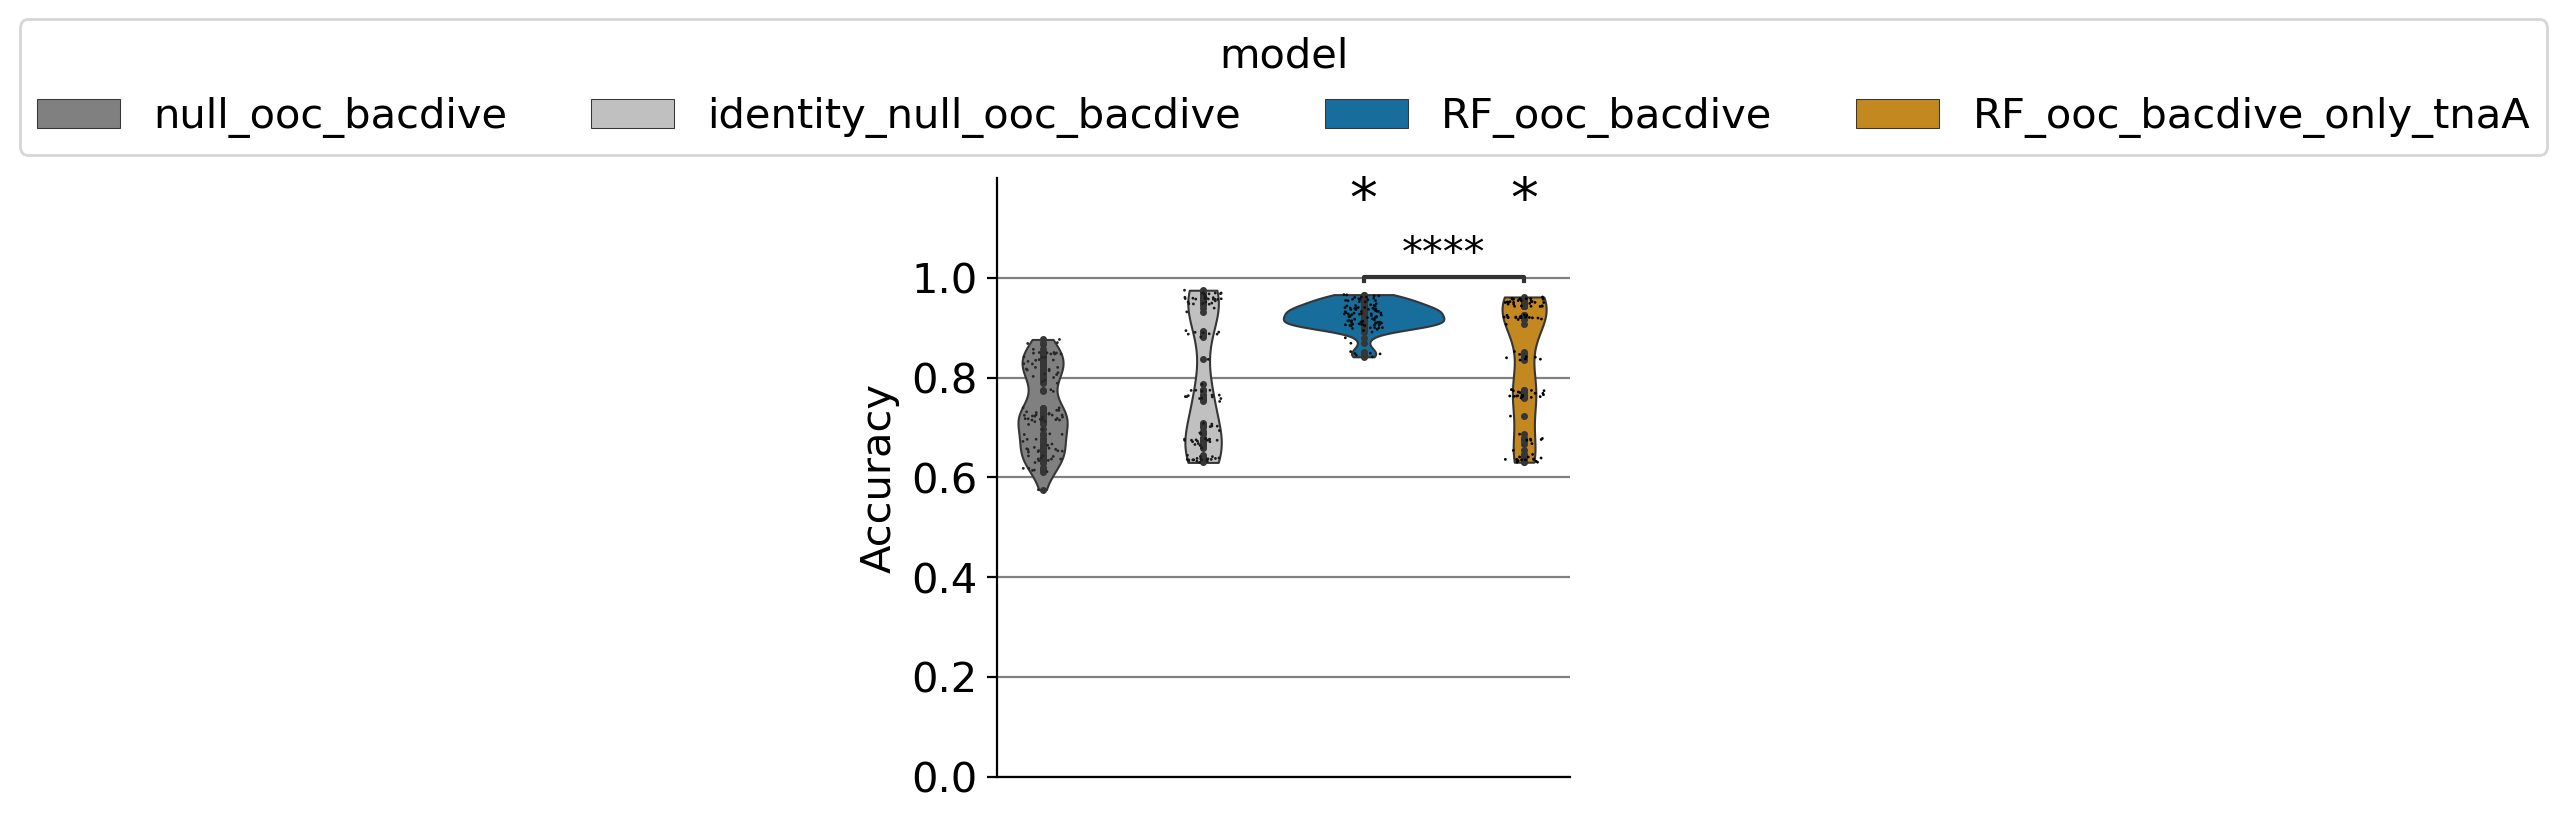

In [35]:

# fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=False, height=4, aspect=1.1,rotate_x=False,single_annotation=False, pair_annotation=True)
#fig.gca().set_title(f"Tryptophan prediction, BacDive dataset")

fig, stats=plot_fancy_model_comparison(results_all, hue_order=['null_ooc_bacdive',
       'identity_null_ooc_bacdive', 'RF_ooc_bacdive', 'RF_ooc_bacdive_only_tnaA' ],stats=stats, 
       model_pairs=[('RF_ooc_bacdive', 'RF_ooc_bacdive_only_tnaA'),
    #    ('RF_ooc_bacdive', 'null_ooc_bacdive'), 
    #    ('RF_ooc_bacdive', 'identity_null_ooc_bacdive')
       ], 
       multi_testing_correction=False, height=4, aspect=1,rotate_x=False,single_annotation=True, y_single_annotation=1.1,pair_annotation=True)

plt.ylabel('Accuracy')
plt.xlabel(None)

# remove x tick 
plt.gca().set_xticks([])

In [ ]:
fi=cal_feature_importance(results_all[(results_all['dataset_name']=='bacdive_no_rnf')], datasets['bacdive_no_rnf']['ko_data'])

In [ ]:
sns.violinplot(data=results_all, x='dataset_name', y='accuracy',hue='carbon_name')

## Identify strains with improved prediction by using rnfG

In [37]:
def get_strain_accuracy_map(df):
    strain_accuracy={}
    for _, row in tqdm(df.iterrows()):
        X=datasets[row['dataset_name']]['ko_data'].loc[row['test_samples']]
        y_pred=row['_model'].predict(X).astype(int)
        y_data=datasets[row['dataset_name']]['growth_data'].loc[row['test_samples'],row['carbon_name']].astype(int)
        correct_pred=(y_pred==y_data).astype(int)
        for sample, pred in zip(row['test_samples'], correct_pred):
            try:
                strain_accuracy[sample].append(pred)
            except KeyError:
                strain_accuracy[sample]=[pred]
    
    for sample in strain_accuracy:
        strain_accuracy[sample]=np.mean(strain_accuracy[sample])
    
    return pd.Series(strain_accuracy)


In [43]:
results_all

,carbon_name,train_samples,test_samples,feature_importances,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,_model,model,dataset_name,is_null_model,null_model,identity_null_pred,n_neighbors,weights,metric
0,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.00021960250186619303, 0.0, 0.0, 0.0, 8.1393...",191,8,10,73,0.936170,0.901235,0.879518,0.959799,0.890244,0.919659,2112,282,"RF(feature_importances=array([0.0002196, 0. ...",RF_ooc,bacdive_no_rnf,NaN,NaN,NaN,NaN,NaN,NaN
1,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11861, 11862, 11865, 11880, 130529, 130530, 1...","[0.0, 2.8134044847136782e-05, 0.00013682547740...",302,7,14,3,0.935583,0.300000,0.176471,0.977346,0.222222,0.576908,2068,326,"RF(feature_importances=array([0.00000000e+00, ...",RF_ooc,bacdive_no_rnf,NaN,NaN,NaN,NaN,NaN,NaN
2,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11267, 11676, 11679, 11680, 11681, 11682, 116...","[0.00010680377649181288, 0.0, 0.0, 0.0, 0.0005...",446,11,52,94,0.895522,0.895238,0.643836,0.975930,0.749004,0.809883,1791,603,"RF(feature_importances=array([0.0001068, 0. ...",RF_ooc,bacdive_no_rnf,NaN,NaN,NaN,NaN,NaN,NaN
3,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11267, 11676, 11679, 11680, 11681, 11682, 116...","[0.00012194414589624171, 0.0, 0.0, 0.0, 0.0007...",442,15,48,102,0.896211,0.871795,0.680000,0.967177,0.764045,0.823589,1787,607,"RF(feature_importances=array([0.00012194, 0. ...",RF_ooc,bacdive_no_rnf,NaN,NaN,NaN,NaN,NaN,NaN
4,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0001665030257118934, 0.0, 0.0, 0.0, 0.0, 0....",216,19,18,98,0.894587,0.837607,0.844828,0.919149,0.841202,0.881988,2043,351,"RF(feature_importances=array([0.0001665, 0. ...",RF_ooc,bacdive_no_rnf,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...",225,22,14,128,0.907455,0.853333,0.901408,0.910931,0.876712,0.906170,2005,389,NaN,RF_ooc,bacdive,NaN,NaN,NaN,NaN,NaN,NaN
496,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[10865, 10866, 10991, 10998, 11023, 11267, 116...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025131...",441,22,21,125,0.929392,0.850340,0.856164,0.952484,0.853242,0.904324,1785,609,NaN,RF_ooc,bacdive,NaN,NaN,NaN,NaN,NaN,NaN
497,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[5.152478765250758e-05, 0.0, 0.0, 0.0, 0.0, 0....",220,22,17,125,0.898438,0.850340,0.880282,0.909091,0.865052,0.894686,2010,384,NaN,RF_ooc,bacdive,NaN,NaN,NaN,NaN,NaN,NaN
498,tryptophan,"[10173, 10433, 10434, 10458, 10460, 10461, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[4.8905917520313666e-05, 0.0, 0.0, 0.0, 0.0, 6...",213,20,13,104,0.905714,0.838710,0.888889,0.914163,0.863071,0.901526,2044,350,NaN,RF_ooc,bacdive,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# results_all=pd.read_pickle(os.path.join("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf","results_all.pk"))

results_all=pd.read_pickle(os.path.join("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf","results_all.pk"))
results_all_prev=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive/results_all.pk")

df=results_all_prev[(results_all_prev['carbon_name']=='tryptophan') & (results_all_prev['model'].isin(['null_ooc','identity_null_ooc','RF_ooc']))]
results_all=pd.concat([results_all, df], axis=0,ignore_index=True)

datasets={'bacdive': {'ko_data': bacdive['ko_data'], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
          # 'bacdive_no_rnf': {'ko_data': bacdive['ko_data'].drop(columns=correlated_genes), 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']},
         'bacdive_only_tnaA': {'ko_data': bacdive['ko_data'].loc[:,['K01667']], 'growth_data': bacdive['growth_data'][['tryptophan']],'tree':bacdive['tree'], 'samples':bacdive['samples'],'carbons':['tryptophan']}
         }
accuracy=get_strain_accuracy_map(results_all[results_all['dataset_name']=='bacdive'])
accuracy_only_tnaA=get_strain_accuracy_map(results_all[results_all['dataset_name']=='bacdive_only_tnaA'])
intersect=np.intersect1d(accuracy.index.values, accuracy_only_tnaA.index.values)
better_strains=(accuracy.loc[intersect]-accuracy_only_tnaA.loc[intersect]).sort_values(ascending=False)
better_strains=better_strains[better_strains>0]
with open("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk", 'wb') as f:
    pickle.dump(better_strains, f)

0it [00:00, ?it/s]


AttributeError: 'float' object has no attribute 'predict'

In [ ]:
better_strains

In [41]:
# Display taxa of improved strains
better_strains=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk")
bacdive_16s=pd.read_csv("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive_16S.aligned.csv").set_index('name')
bacdive_16s.index=bacdive_16s.index.str.replace('bacdive_','')
bacdive_16s.loc[better_strains]['lca_tax_slv'].str.split(';', expand=True)

""
name


In [ ]:
pred=results_all.apply(get_model_predictions, result_type='expand', axis=1)

In [ ]:
# TODO: where they are on the tree

# Figure 5

## 4A: color KEGG pathways

Use [KEGG Mapper Color](https://www.genome.jp/kegg/mapper/color.html) to plot an example. 

In [ ]:
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")

In [ ]:
def generate_kegg_color_texts(df,c, keys=['by_pathway','by_k3_path_directed','by_reaction'],compound_color='red',edge_colors=['yellow','pink','cyan']):
    row=df.loc[c]
    print(f"{row['carbon']}\t{compound_color}")
    colors={}
    for key, edge_color in zip(keys, edge_colors[:len(keys)]):
        for ko in row[key]:
            colors[ko]=edge_color
    
    for ko, c in colors.items():
        print(f"{ko}\t{c}")
    



In [ ]:
generate_kegg_color_texts(df,'Raffinose',keys=['by_k2_path_undirected','by_reaction'])

## 4B. KEGG restricted models

See figure_4B.ipynb

# Archive

## 2A

In [ ]:
# FBA
# The standard pipeline class doesn't work well for this because it checks that the training set and test set must have non-zero samples. Borrow the _pickleable_run_model function. 

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba'
results_all.append(results)

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba_gapfill'
results_all.append(results)

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_all.append(results_bernoulli)

In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('zeqian_','')
X=X.loc[zeqian['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1,p=None)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results_all.append(results)


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

## 2C

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

In [ ]:
# p-value


results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

stat=compare_models(results_all[results_all['dataset_name']=='matti_16s'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('NN',single_model_summary),
                        ('NN_ooc',single_model_summary),
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/matti_stat.pk")

In [ ]:
df=stat[['NN_null_significant','NN_ooc_null_ooc_significant']]


## Matti

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk")

# results_all.append(results_bernoulli)

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('matti_','')
X=X.loc[matti['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")
# results_all.append(results)


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")

In [ ]:
# Plot
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)


In [ ]:
# Option 1
fig=plt.figure(figsize=(5,5))
sns.scatterplot(data=stat, x='NN_null_t',y="NN_ooc_null_ooc_t", hue='NN_null_significant', style='NN_ooc_null_ooc_significant')
# legend on the right outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# draw a line y=x
x=np.linspace(stat['NN_null_t'].min(),stat['NN_null_t'].max(),100)
plt.plot(x,x,'r--')


In [ ]:
# Option 2
fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.scatterplot(data=stat, x='NN_null_t',y="NN_mean", hue='NN_null_significant',ax=axes[0])
sns.scatterplot(data=stat, x='NN_ooc_null_ooc_t',y="NN_ooc_mean", hue='NN_ooc_null_ooc_significant',ax=axes[1])

Another option: x = mean_growth, y=NN_null_t

Also, how to deal with negative t stat? 

TODO: OOC

## Bacdive

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
p=Pool(28)

In [ ]:
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False, 
                       ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_bernoulli.pk")
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk")

# results_all.append(results_bernoulli)

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=20,threads=28,p=p,carbons=carbons,save_models=False,
                        ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_nn_genome.pk")
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

In [ ]:

# Nearest neighbor, 16S
# from genomics_utils import IO
# sixteenS_data=IO.read_fasta(f"{DIR_data}/bacdive/bacdive_16S.aligned.fna",df=True)
# sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
# X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
# X.index=X.index.str.replace('bacdive_','')
# X=X.loc[bacdive['samples']]

# pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
#                         split_method='random',splitter_params={'test_set_ratio':0.2},
#                         n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
# pipe.generate_splits(X,growth_data)
# results=pipe.run()
# results['model']='nn_16S'
# results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_16S.pk")

# results_all.append(results)


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
                    ],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)
# x axis rotate 90 degree
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



In [ ]:
# # Run this cell for testing 

# threads=1

# models={'RF':[RF,None], 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}


# split_params={'random': {
#                  'split_method':'random',
#                  'splitter_params': {'test_set_ratio':0.2}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         'ooc': {
#                  'split_method':'ooc',
#                  'splitter_params': {'test_set_range':(0.1,0.25), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         # 'loo':{
#         #          'split_method':'leave_one_out',
#         #          'splitter_params': {}, 
#         #          'n_splits':2,
#         #          'threads': threads,
#         #          'save_models':False
#         #          }
#         }

##  2A

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='zeqian_16s'], 
                    model_pairs=[
                        ('fba','null',one_sample_test),
                        ('fba_gapfill','null',one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/2A/stat.pk")

### Plot

In [ ]:
plt.rcParams['axes.axisbelow'] = True


In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/2A/stat.pk").set_index('carbon_name')

df=results_all[results_all['dataset_name']=='zeqian_16s']
hue_order=['null','fba','NN','null_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7'] # ,'#009E73'

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
# ax.grid()

# x axis rotate 90 degree
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Draw FBA line by wizardry 

half_violin=0.4/len(hue_order)
epsilon=0.03
for i,carbon in enumerate(ax.get_xticklabels()):
    y=df[df['carbon_name']==carbon.get_text()]['accuracy'].values[0]
    x=i-half_violin*(len(hue_order)-3)

    ax.plot([x-half_violin+epsilon,x+half_violin-epsilon],[y,y],color=colors[1],linewidth=2)


In [ ]:

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('fba','null'),('NN','null'),('NN_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

## 3A

In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_cache=os.path.join(DIR_figure,'cache',f'{dataset_name}_{model_name}.pk')
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue
            ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']
            pipe=PredictionPipeline(Model, tree=tree, carbons=carbons, p=p,  ff_results=ff_cache, **pipe_params)
            pipe.generate_splits(ko_data,growth_data)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
            print(f"Finished {dataset_name} {model_name} ")
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")


In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stat=compare_models(results_all, 
                    model_pairs=[
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('RF','null',ttest_permutation),
                        ('RF_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk")

### Plot

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk").set_index('carbon_name')

df=results_all
hue_order=['null','RF','NN','null_ooc','RF_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7','#009E73'] 

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('NN','null'),
            ('NN_ooc','null_ooc'),
            ('RF','null'),
            ('RF_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

## BacDive

In [ ]:
results_all['carbon_name_sample_number']=results_all['carbon_name']+'_'+(results_all['train_samples'].str.len()+results_all['test_samples'].str.len()).astype(str)
sns.catplot(data=results_all, col='carbon_name_sample_number',x='model',y='balanced_accuracy',kind='violin',cut=0,col_wrap=5,order=['null','NN','RF','null_ooc','NN_ooc','RF_ooc'])
plt.gcf()

In [ ]:
# BacDive
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']
results_all=[]

#TODO: 16S for bacdive is too large. Need to use the pre-calcualted distance matrix for bacdive. Do this later. 

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':bacdive['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':bacdive['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={ 
        # 'matti_16s': [sixteenS_data,growth_data],
          'bacdive_genome': [ko_data,growth_data]
        }


In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='bacdive_genome'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        (('NN','null'),ttest),
                        (('NN_ooc','null_ooc'),ttest)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_stat.pk")